In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack,signal
import matplotlib
from matplotlib.ticker import ScalarFormatter
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval)
import scipy
import json
import subprocess
import os

In [5]:
class spectra_2d:
    
    #------------------
    
    def __init__ (self, path_etc_local, path_etc_input, path_input_modi, \
                  path_etc_output, aperture_size, date, order_number=[], order_window=[], \
                  target = None, model_name=None, planet_p=None):
        
        if target not in ['star', 'planet']:
            print ('Target not valid, please choose one from "star" or "planet" ') #The target can only be either star or planet    
        
        self.target = target #set up the target
        self.path_etc_local=path_etc_local #the local path of the etc script linked to website service 
        self.path_input = path_etc_input #the path of input data for etc
        self.path_input_modi = path_input_modi #the path to save the input data after modification in codes
        
        self.path_output = path_etc_output #the path to save the output data from etc
        
        if os.path.exists(self.path_output) == False:  #create the paths of output files if they don't exist 
            subprocess.call(['mkdir', self.path_output]) 
        
        self.model_name = model_name
        self.date=date
        
        self.order_num = order_number
        self.order_wave = order_window
        
        self.planet_p = planet_p #planet position
        
        if aperture_size%2 == 0: #we need the odd number for increasing the aperture size later
            print ("Warning: It's better to use an odd number, the final size is better to be %s"%(aperture_size-1))
            
        self.aperture_size = aperture_size
        self.aperture_list = np.arange(1, self.aperture_size+1, 2).tolist() # for example: 1, 3, 5 ...35, we create the list with ascending numbers for the aperture size 
    
    #------------------
    # The function aimes to create and save the output data from etc in .json format automatically
    # With the list created in the initial function, we are able to produce a set of output data with ascending apeture sizes, e.g. from 1, 3, 5...to 35
    # Later in the next few functions, we gonna make difference with these output data to retrieve the 2-D spectra.
    
    def output_json (self, star_template=None):
    #If you want to use your own stellar template, please pass the path in the arugment above 
        
        with open(self.path_input, 'r') as f:
            data = json.load(f)
            # Modify the contents of the JSON file
            for i in self.aperture_list:
            
                data['seeingiqao']['aperturepix']= float(i)
                
                # Update the modified JSON file to disk
                with open(self.path_input_modi, 'w') as f:
                    json.dump(data, f)
                
                subprocess.call(['mkdir', self.path_output+'ascii_%s/'%i])
        
                if self.target == 'star':
                    
                    if star_template==None:

                        subprocess.call(['python', self.path_etc_local, 'CRIRES', self.path_input_modi, \
                             '-o', self.path_output+'ascii_%s/'%i+'output_%s_%s_AO.json'%(self.date, i)])
                        
                    else:
                        
                        subprocess.call(['python', self.path_etc_local, 'CRIRES', self.path_input_modi, \
                         '-u' , star_template, '-o', self.path_output+'ascii_%s/'%i+'output_%s_%s_AO.json'%(self.date, i)])
                        
        
                elif self.target == 'planet':
                    subprocess.call(['python', self.path_etc_local, 'CRIRES', self.path_input_modi, \
                         '-u' , self.model_name, '-o', self.path_output+'ascii_%s/'%i+'output_p_%s_%s_AO.json'%(self.date, i)])
        
        print ('the ETC calculation is done, the output file is saved at %s'%self.path_output)
    
    #------------------
    # This function works on converting the format froom json to ascii assoicated with a script provided by ETC page of CRIRES+
    # ATTENZIONE: NOT ALL OUTPUT DATA CAN BE SUCCESSFULLY CONVERTED
    # please check carefully for the .ascii files and if you can, just use .json 
    
    def json2ascii (self, path_json2ascii):
        
        if self.target == "star":      
            
            for i in self.aperture_list:
                subprocess.call(['cp', '-r', path_json2ascii, self.path_output+'ascii_%s/'%i])
                subprocess.call(['python', self.path_output+'ascii_%s/'%i+'etc_json2ascii.py',\
                                 self.path_output+'ascii_%s/'%i+'output_%s_%s_AO.json'%(self.date, i)])
        
        if self.target == 'planet':            
            for i in self.aperture_list:
                subprocess.call(['cp', '-r', path_json2ascii, self.path_output+'ascii_%s/'%i])
                subprocess.call(['python', self.path_output+'ascii_%s/'%i+'etc_json2ascii.py',\
                                 self.path_output+'ascii_%s/'%i+'output_p_%s_%s_AO.json'%(self.date, i)])
    
    #------------------
    # This functions works on converting .ascii files into .txt files 
    
    def ascii2txt (self, output, order_number=None):   
        
        if order_number == None:
            order_number=self.order_num
        
        for i in self.aperture_list:

            for j in [1,2,3]:
                for x in order_number:
                    for m in output:
                        try:
                            if self.target == 'star':
                                file=self.path_output+'ascii_%s/'%i+\
                                'output_%s_%s_AO.json_order:%s_det:%s_%s.ascii'%(self.date, i, x, j, m)
                            elif self.target =='planet':
                                file=self.path_output+'ascii_%s/'%i+\
                                'output_p_%s_%s_AO.json_order:%s_det:%s_%s.ascii'%(self.date, i, x, j, m)
                            dat=[]
                            with open(file, 'r') as f:
                                lines = f.readlines()
                                dat += [line.split() for line in lines[2:]]


                            with open(self.path_output+'ascii_%s/'%i+'converted_data_%s_%s_%s.txt'%(x,m,j), 'w') as f:
                                # Write the header line
                                if m == 'psf':
                                    f.write("angle (arcsec)\tPSF (norm)\n")
                                elif m == 'snr_snr':
                                    f.write('wavelength (m)\tsnr\n')
                                elif m == 'sed_target':
                                    f.write('wavelength (m)\tflux (Jsm-2m)\n')
                                else:
                                    f.write("wavelength (m)\tcounts\n")
                                # Write the data
                                for line in dat:
                                    f.write("\t".join(line) + "\n")


                        except FileNotFoundError:
                            print('File Not Found: %s-%s-%s-%s'%(i,x,j,m))
                            continue
                            
                    print('txt_done_%s_%s_%s'%(i,x,j))
    
    #------------------
    # This is the core function of this class.
    # The aim of this function is to re-distribute the signal in a 2-D plane 
            
    def signal(self, detectors, contribution=None, nor=None, focal_plane=None):
        
        #load parameters------
        #focal_plane: set up the size (in pixels) 
        #detectors: number of detectors
        #contribution: sky, target or total
        #nor: normalization the map or not, the option is TRUE or FALSE; The default setting is normalization
        
        self.focal_plane = np.zeros(focal_plane)
        self.detectors = detectors
        
        order_number = self.order_num
        order_window = self.order_wave 
        
        if contribution not in ['sky', 'target', 'tot']:
            print('Stupid boy, you need to choose one from [sky, target, tot]')
            
        
        inter = np.arange(0, int(np.ceil(self.aperture_size/2)),1)
        name = self.aperture_list
        
        
        #build the dict for the data with ascending aperture sizes
        #the dict follows the structure['aper': serial number (0,1,2,3,...17)['wavelength(nm)','counts'], 'name': aperture size (1,3,5...35)]
        dat_tot = {'aper': inter.tolist(), 'name': name}
        
        for n in inter.tolist():
            i = 2*n+1
            dat_tot['aper'][n] = {'wavelength(nm)':[],'counts':[]}
            
            for nu in range(1, detectors+1):
                for order in order_number:
                    data_sig=pd.read_table(self.path_output+'ascii_%s/'%i+'converted_data_%s_signals_obs%s_%s.txt'%(order,contribution, nu))
                    dat_tot['aper'][n]['wavelength(nm)'].append(data_sig['wavelength (m)'].values*1e9)
                    dat_tot['aper'][n]['counts'].append(data_sig['counts'].values)
            
        #set up the dataframe consisting of the counts for each row . Let's start from the central pixel (with aper size =1)
        wave_count_0=pd.DataFrame(data=dat_tot['aper'][0])
                
        #make difference for each two aperture sizes and write the data into the dataframe wave_count_0
        
        for i in inter[1:]:
            
            wave_count_i=pd.DataFrame(data=dat_tot['aper'][i])
            wave_count_i_1=pd.DataFrame(data=dat_tot['aper'][i-1])
            if np.where((wave_count_i['wavelength(nm)']-wave_count_i_1['wavelength(nm)']).all==0, True, False) == False:
                dat_diff=(wave_count_i['counts']-wave_count_i_1['counts'])/2
            else:
                print('Wrong result! The wavelength range is not matched')
            wave_count_0['dat_diff_%s'%i]=dat_diff
            
        #organize wave_count_0 for ploting: rename, explode, and sort the values by ascending wavelength
        
        wave_count_0=wave_count_0.rename(columns={'counts':'dat_diff_0'})
        name_list=wave_count_0.columns.to_list()
        wave_count_ex=wave_count_0.explode(name_list).reset_index()
        wave_count_sort=wave_count_ex.sort_values(by='wavelength(nm)').reset_index()
        
        return (wave_count_sort)
            
    #------------------
    # This is used to virualize the signal as a 2-D spectra.
    
    def plot_signal(self, wave_count_sort, max_percentile, save_path, interv, minimum=None, Nor=None):
        
        # wave_count_sort: the data set of the focal plane
        # max_percentile: the maximum percentile for the plot
        # save_path: the path to save your plots
        # minimum: minimum percentile for the plot
        # Nor: if None, normalization is following the func: ImageNormalize(focal_plane, interval= interv, vmax=ceil, vmin=minimum)
        
        #set up the fontsize
        font = {'size': 4}
        plt.rcParams.update({'font.size': font['size']})
        
        #plot data with imshow
        plt.ion() #enable the interactive mode
        row = len(self.order_num)
        fig, axs=plt.subplots(row, 1, dpi=500, sharex=True, sharey=True)
        focal_plane = self.focal_plane
        
        for n_order in range(row):

            one_order=wave_count_sort.loc[(wave_count_sort['wavelength(nm)']<=self.order_wave[n_order][1])&(wave_count_sort['wavelength(nm)']>=self.order_wave[n_order][0])]
            
            central_pix=int(np.ceil(focal_plane.shape[0]/2))
            
            pixel_posi=len(self.aperture_list)
            for x in range(0,pixel_posi):
                loc_up=central_pix+x
                loc_be=central_pix-x  
                self.focal_plane[loc_up,0:len(one_order)]=one_order['dat_diff_%s'%x]
                self.focal_plane[loc_be,0:len(one_order)]=one_order['dat_diff_%s'%x]
            
            ff=axs[n_order]

            ceil= np.percentile(focal_plane, max_percentile)
            if minimum == None:
                minimum=np.min(focal_plane)
                
            nor = ImageNormalize(focal_plane, interval= interv, vmax=ceil, vmin=minimum)
            
            max_order = np.max(self.order_num)

    
            ff.set_title('order%s: %s nm - %s nm'%(max_order-n_order,self.order_wave[n_order][0],self.order_wave[n_order][1]),fontsize=5)
            if Nor == None or Nor == True:
                ff.imshow(focal_plane,norm = nor ,cmap='Greys_r')
                fig.colorbar(ff.imshow(focal_plane, norm=nor, cmap='Greys_r'), ax=axs[n_order], shrink=0.5, aspect=60, \
                         location='bottom',pad=0.2)
            elif Nor == False:
                ff.imshow(focal_plane, vmin=minimum, vmax=ceil, cmap='Greys_r')
                fig.colorbar(ff.imshow(focal_plane, vmin=minimum, vmax=ceil, cmap='Greys_r'), ax=axs[n_order], shrink=0.3, aspect=50, \
                         location='bottom',pad=0.2)
            else:
                print('Stupid sweet, you just passed a wrong value to Nor. It should be on from True, Flase or None')
                
            ff.set_aspect(8)
            ff.axis('off')
            '''
            if "plot_combination" == True:
                ff.hlines(y=1024+self.planet_p, xmin=0, xmax=self.focal_plane.shape[1], ls='--',colors='gray', linewidth=0.8)
            '''
        plt.subplots_adjust(hspace=1)
        plt.ylim(loc_be-1,loc_up+1)
        plt.suptitle('focal plane %s \n$e^-$/pix/exposure'%str(focal_plane.shape),x=0.5,fontsize=9)

        plt.savefig(save_path)
        plt.close() 
        
    #------------------
    #This function works for combining all signals together in one plot to to simulate the observation.
    
    def combine(self, data_star, data_p, \
                plot_combination=None, d=None, sky=True, noise=True, data_sky=None,\
                ron=None, dark=None, focal_plane=None,\
                 plot_save_path=None):
        
        # data_star, data_p: the dataset of the whole focal plane for star and planet
        # plot_combination: if plot the combination signal map or not, 
        # d: The projected separation 
        # sky: [True, False] if true, consider the sky contribution. The default is True.
        # noise: [True, False] if true, consider the noise terms. The defalut is True.
        # data_sky: The path the sky data. 
        # ron: read-out-noise value
        # dark: value of dark counts
        # focal_plane: the size of focal plane, (interger, interger). The defalut setting is to use the one from __init__
        # plot_save_path: the path to save plots
        
        font = {'size': 4}
        plt.rcParams.update({'font.size': font['size']})
        
        if noise not in [True, False]:
            
            print('Stupid, you just passed a nonsense value to noise. It should be one from [None, True, False]')
            
        if sky not in [True, False]:
            
            print('Stupid, you just passed a nonsense value to sky contribution. It should be one from [None, True, False]')
            
        if self.planet_p == None:
            self.planet_p = d 
            
        elif d!=0 and self.planet_p != None:
            print ('Stupid! you already choose one position in the initial function. I will not change the value!')
            d = self.planet_p
            
        if focal_plane != None:
            self.focal_plane = np.zeros(focal_plane)
        
            
        row=len(self.order_num)
        pixel_posi=len(self.aperture_list)
        
        signal_tot = np.zeros((row, self.focal_plane.shape[0], self.focal_plane.shape[1]))
        for n_order in range(row):
            focal_plane = self.focal_plane
            cons_plane = self.focal_plane
            cons_nnoise_plane = self.focal_plane
            
            order_w=self.order_wave

            one_order_s=data_star.loc[(data_star['wavelength(nm)']<=order_w[n_order][1])&(data_star['wavelength(nm)']>=order_w[n_order][0])]
            one_order_p=data_p.loc[(data_p['wavelength(nm)']<=order_w[n_order][1])&(data_p['wavelength(nm)']>=order_w[n_order][0])]
            if sky == True: 
                one_order_k=data_sky.loc[(data_sky['wavelength(nm)']<=order_w[n_order][1])&(data_sky['wavelength(nm)']>=order_w[n_order][0])]
            
            central_pix=int(np.ceil(self.focal_plane.shape[0]/2))
            
            for x in range(0, pixel_posi):

                #add stellar signal
                loc_up=central_pix+x
                loc_be=central_pix-x

                focal_plane[loc_up,0:len(one_order_s)]=one_order_s['dat_diff_%s'%x]
                focal_plane[loc_be,0:len(one_order_s)]=one_order_s['dat_diff_%s'%x]
                
                
                if sky == True:
                    #add sky signal 
                    focal_plane[loc_up,0:len(one_order_k)]+=(one_order_k['dat_diff_%s'%x])
                    focal_plane[loc_be,0:len(one_order_k)]+=(one_order_k['dat_diff_%s'%x])
                    
                    
                if noise == True:
                    #add noise
                    noi=ron+dark
                    focal_plane[loc_up,0:len(one_order_k)]+=noi
                    focal_plane[loc_be,0:len(one_order_k)]+=noi
                    

                #add planet signal
                if d+x <= pixel_posi:
                    loc_up_p=central_pix+d+x
                    loc_be_p=central_pix+d-x
                    focal_plane[loc_up_p,0:len(one_order_p)]+=one_order_p['dat_diff_%s'%x]
                    focal_plane[loc_be_p,0:len(one_order_p)]+=one_order_p['dat_diff_%s'%x]

                
            signal_tot[n_order]=focal_plane
            
        if plot_combination == True:

            central_pix = focal_plane.shape[0]/2
            width = len(self.aperture_list)

            fig, axs=plt.subplots(7,1,dpi=200, sharex=True, sharey=True)

            for n_order in range(0, row):

                ceil=np.percentile(focal_plane, 99.5)    
                nor = ImageNormalize(focal_plane, interval= ZScaleInterval(contrast=0.2), vmax=ceil,vmin=np.min(focal_plane))

                ff=axs[n_order]
                ff.imshow(signal_tot[n_order],norm=nor ,cmap='Greys_r')
                ff.set_title('order%s: %s nm - %s nm'%(29-n_order,order_w[n_order][0],order_w[n_order][1]),fontsize=5)
                fig.colorbar(ff.imshow(signal_tot[n_order], norm=nor, cmap='Greys_r'), ax=axs[n_order], shrink=0.3, aspect=50, \
                             location='bottom',pad=0.2)

                ff.hlines(y=central_pix+d,xmin=0,xmax=focal_plane.shape[1],ls='--',colors='gray', linewidth=0.8)
                ff.axis('off')
                ff.set_aspect(8)
                ff.set_ylim(central_pix-width,central_pix+width)

            fig.subplots_adjust(hspace=1.3)
            fig.suptitle('focal plane (%s*%s)\n$e^-$/pix/exposure'%(focal_plane.shape[0], focal_plane.shape[1]),\
                         x=0.5,fontsize=9)    
                
            plt.close()
        return (signal_tot,fig)
         
    
#-----------------------------------------
#Function for loading .json files

def load_json(path, permit):
    with open(path, '%s'%permit) as f:
        data=json.load(f)
        
    return (data)              

In [8]:
#The class focuses on processing theoretical spectra of planets.  
class planet_para:
    
    #FORMAT SUPPORT:     
    #disper_planet, disper_star, disper_sky: pd.DataFrame
    #data_planet, data_star, data_sky: np.ndarray or pd.DataFrame
    
    def __init__(self, disper_planet=None, disper_star=None,\
                 data_planet=None, data_star=None, disper_sky=None, data_sky=None):
        
        # disper_planet, disper_star, disper_sky: the dataset of the 2-D flux distribution of the planet, the star and the sky, in pd.Dataframe
        # data_planet, data_star, data_sky: the dataset of the 1-D extracted spectrum of the star, the planet, and the sky
        
        self.disper_planet = disper_planet
        self.data_planet = data_planet
        
        self.disper_star = disper_star
        self.data_star = data_star
        
        self.disper_sky = disper_sky
        self.data_sky = data_sky
        

        
    #-------------------
    #This function aims to calculate the color indexes of two given band for the spectrum.
    
    def color_index(self,\
        band1_w=None, band2_w=None, transmission1=None, transmission2=None,\
        zero1=None, zero2=None, atmosphere='False',\
        c1=None, c2=None,\
        airmass=None):
        
        # band1_w, band2_w: two selected bands 
        # transmission1, transmission2: transmission profiles for the two bands
        # zero1, zero2: zero flux for two bands. ATTENZIONE: flux not magnitude!
        
        # --Atmospheric extinction parameters
        # --- atmosphere: The default setting is 'False', means no atmospheric extinction is considered. 
        # --- c1, c2: atmospheric extinction coefficients
        # --- airmass: only need to be defined when you would like to calculate the atmospheric extinction.
            
        if isinstance(self.data_planet, np.ndarray):

            wave = self.data_planet[0]
            flux = self.data_planet[1]

            mask_1=[(wave>band1_w[0])&(wave<band1_w[1])]
            mask_2=[(wave>band2_w[0])&(wave<band2_w[1])]

            data_1=np.array([self.data_planet[0][mask_1],self.data_planet[1][mask_1]])
            transmission_1=np.interp(data_1[0], transmission1[0], transmission1[1])
            
            data_2=np.array([self.data_planet[0][mask_2],self.data_planet[1][mask_2]])
            transmission_2=np.interp(data_2[0], transmission2[0], transmission2[1])

            int_flux_1= np.trapz(data_1[1]*transmission_1, data_1[0])/np.trapz(transmission_1, data_1[0])
            int_flux_2= np.trapz(data_2[1]*transmission_2, data_2[0])/np.trapz(transmission_2, data_2[0])
            
            

        elif isinstance(self.data_planet, pd.DataFrame):

            wave = self.data_planet['wave']
            flux = self.data_planet['flux']

            mask_1=[(wave>band1_w[0])&(wave<band1_w[1])]
            mask_2=[(wave>band2_w[0])&(wave<band2_w[1])]

            data_1=self.data_planet[mask_1]
            transmission_1=np.interp(data_1[0], transmission1[0], transmission1[1])
            
            data_2=self.data_planet[mask_2]
            transmission_2=np.interp(data_2[0], transmission2[0], transmission2[1])

            int_flux_1= np.trapz(data_1.flux*transmission_1, data_1.wave)/np.trapz(transmission_1,  data_1.wave)
            int_flux_2= np.trapz(data_2.flux*transmission_2, data_2.wave)/np.trapz(transmission_2,  data_2.wave)
        
        else:
            
            print ('Sweet but dumb, we do not support this format. Choose one from np.ndarray or pd.DataFrame.')
            
            
        #lam_eff_1=np.trapz(data_1.flux*transmission_1*(data_1.wave**2), data_1.wave)/np.trapz(data_1.flux*transmission_1*(data_1.wave), data_1.wave)
        #lam_eff_2=np.trapz(data_2.flux*transmission_2*(data_2.wave**2), data_2.wave)/np.trapz(data_2.flux*transmission_2*(data_2.wave), data_2.wave)
        
        c=scipy.constants.speed_of_light
        
        #zero_flux_1=zero1*1e-23*(c/(lam_eff_1**2))
        #zero_flux_2=zero2*1e-23*(c/(lam_eff_2**2))
        
        if atmosphere=='True':
            mag_1=-2.5*np.log10(int_flux_1/zero1)-c1*(airmass-1)
            mag_2=-2.5*np.log10(int_flux_2/zero2)-c2*(airmass-1)
        
        else:
        
            mag_1=-2.5*np.log10(int_flux_1/zero1)
            mag_2=-2.5*np.log10(int_flux_2/zero2)
              
        
        c_index=mag_1-mag_2
        #c_index=-2.5*np.log10(int_flux_1/int_flux_2)+(zero1-zero2)+(c1-c2)*(airmass-1.0)
        
        return (c_index, mag_1, mag_2, data_1, transmission_1, data_2, transmission_2)
    
    
    #This function aims to calculate both the intrinsic and the in-situ planet-to-star flux ratio 
    def p_2_s (self,  order_num, plot=True, planet_posi= None, sky=False):
        
        #if planet position is setted as False, only intrinsic p2s ratio is calculated 
        
        font = {'size': 4}
        plt.rcParams.update({'font.size': font['size']})
        
        if sky==True:
            self.disper_star+=self.disper_sky

        p_2_s_intr=self.disper_planet['dat_diff_0']/self.disper_star['dat_diff_0']
        p_2_s_intr=np.log10(p_2_s_intr)
        p_2_s_intr[np.isinf(p_2_s_intr)]=np.nan
        
        
        
        if planet_posi != False:
            
            p_2_s_planet = self.disper_planet['dat_diff_0']/self.disper_star['dat_diff_%s'%planet_posi]
            p_2_s_planet = np.log10(p_2_s_planet)
            p_2_s_planet[np.isinf(p_2_s_planet)]=np.nan
            
        else:
            p_2_s_planet = []
        
        
        
        if plot==True:

            fig,axs=plt.subplots(len(order_num),3)

            for i in range(len(order_num)):
                for j in range(3):
                    ax=axs[i][j]
                    ind=3*i+j
                    wave_range = self.disper_planet.loc[2045*ind:2045*(ind+1)]['wavelength(nm)']
                    mask_in=np.where(p_2_s_intr[2046*ind:2046*(ind+1)]==np.nan, True, False)
            
                    ax.plot(p_2_s_intr[2046*ind:2046*(ind+1)],\
                            linewidth=0.6, alpha=0.7)
                

                    if ind + 3 >= len(order_num)*3:
                        ax.set_xlabel('wavelength (nm)')
                    if j%3 ==0: 
                        ax.set_ylabel('$log_{10}(f_p/f_s)$')
                    if ind%3 !=0 :
                        ax.set_yticks([])
                        
                    ax.set_title('order:%s, detector:%s'%(order_num[i], j+1))
                    #ax.set_yscale('log')
                    
                    mi=np.nanmin(p_2_s_intr[2046*ind:2046*(ind+1)])
                    mi=np.round(mi,2)
                    ma=np.nanmax(p_2_s_intr[2046*ind:2046*(ind+1)])
                    ma=np.round(ma,2)
                    
                    ax.set_ylim(mi, ma*1.05)
                    ax.set_yticks(np.linspace(mi, ma, 3))
                    
                    tick=np.linspace(wave_range.min(),wave_range.max(), 3, dtype='int')
                    ax.set_xticks(ticks=np.linspace(2046*ind, 2046*(ind+1),3), labels=tick)
                    #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

            fig.suptitle('planet-to-star flux ratio')
            fig.subplots_adjust(hspace=1.3,wspace=0.3)
            plt.tight_layout()
            plt.close()
            
            
            if planet_posi != False:
                
                fig1,axs1=plt.subplots(len(order_num),3)

                for i in range(len(order_num)):
                    for j in range(3):
                        ax1=axs1[i][j]
                        ind=3*i+j
                        wave_range = self.disper_planet.loc[2045*ind:2045*(ind+1)]['wavelength(nm)']
                        mask_pl=np.where(p_2_s_planet[2046*ind:2046*(ind+1)]==np.nan, True, False)
                        
                        ax1.plot(p_2_s_planet[2046*ind:2046*(ind+1)],\
                                 linewidth=0.6, alpha=0.7)                     

                        if ind + 3 >= len(order_num)*3:
                            ax1.set_xlabel('wavelength (nm)')
                        if j%3 ==0: 
                            ax1.set_ylabel('$log_{10}(f_p/f_s)$') 
                            
                            
                        ax1.set_title('order:%s, detector:%s'%(order_num[i], j+1))
                        #ax1.set_yscale('log')
                                  
                        mi=np.nanmin(p_2_s_planet[2046*ind:2046*(ind+1)])
                        mi=np.round(mi,2)
                        ma=np.nanmax(p_2_s_planet[2046*ind:2046*(ind+1)])
                        ma=np.round(ma,2)
                        
                        ax1.set_ylim(mi, ma*1.05)
                        ax1.set_yticks(np.linspace(mi, ma, 3))
                        
                        tick=np.linspace(wave_range.min(),wave_range.max(),3, dtype='int')
                        ax1.set_xticks(ticks=np.linspace(2046*ind, 2046*(ind+1),3),labels=tick)
                        #ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
                        
                        
                fig1.suptitle('planet-to-star flux ratio at planet position')
                fig1.subplots_adjust(hspace=1.3, wspace=0.3)
                plt.tight_layout()
                plt.close()
               
                
            
                return(p_2_s_intr, p_2_s_planet, fig, fig1)
            
            else:
        
                return (p_2_s_intr, p_2_s_planet, fig)
        
        else:
            
            return (p_2_s_intr, p_2_s_planet)
        
    #-------------------
    
    def mag_convert(self, flux_ratio, stellar_mag, error_b=0., error_p=0.):
        
        error=np.array([error_b, error_p])
        planet_mag_p = stellar_mag - 2.5*np.log10(flux_ratio+error[1])
        planet_mag_b = stellar_mag - 2.5*np.log10(flux_ratio-error[0])
        planet_mag = stellar_mag - 2.5*np.log10(flux_ratio)

        return ([planet_mag_b, planet_mag, planet_mag_p])
    

In [10]:
import spectra_2d

import analysis

In [15]:
#-----------------------------------------
#Function for loading .json files

def load_json(path, permit):
    with open(path, '%s'%permit) as f:
        data=json.load(f)
        
    return (data) 

data=load_json('/Volumes/JCP_work 3/thesis_ms/input_1709_AO.json','r')
data

{'application': {'executiondate': '2023-09-17T12:20:19.552Z',
  'version': 'P113',
  'instrument': 'crires2'},
 'target': {'morphology': {'morphologytype': 'point'},
  'sed': {'sedtype': 'spectrum',
   'spectrum': {'spectrumtype': 'template',
    'params': {'ctlg': 'MARCS',
     'objtype': 'star',
     'spectype': 'p7250:g+4.0:m0.0:t02:st:z+0.00:a+0.00:c+0.00:n+0.00:o+0.00'}}},
  'brightness': {'brightnesstype': 'mag',
   'params': {'magband': 'K', 'mag': 6.41, 'magsys': 'vega'}}},
 'seeingiqao': {'mode': 'aongs',
  'aperturepix': 35,
  'params': {'turbulence_category': 70, 'gsmag': 9}},
 'timesnr': {'mode': 'ndit', 'DET1.DIT': 120, 'DET1.NDIT': 18},
 'sky': {'airmass': 1.2, 'moon_fli': 0.5, 'pwv': 2.5},
 'output': {'throughput': {'atmosphere': True,
   'telescope': True,
   'instrument': True,
   'blaze': True,
   'enslittedenergy': True,
   'detector': True,
   'totalinclsky': True},
  'snr': {'snr': True, 'noise_components': True},
  'sed': {'target': True, 'sky': True},
  'signals'

In [17]:
data_pp=load_json('/Volumes/JCP_work 3/thesis_ms/input_1709_p_AO.json', 'r')
data_pp['target']['brightness']['params']['mag']

17.14

In [18]:
#data=load_json('./modi_input_0607_p_AO_2.json','r')
out_put=[]
for i in data['output']:
    if i == 'psf':
        out_put.append('%s'%i)
    else:   
        for j in data['output'][i]:
            out_put.append('%s_%s'%(i,j))
out_put=[string.lower() for string in out_put]        

In [20]:
simu_star=spectra_2d.spectra_2d(path_etc_local='/Volumes/JCP_work 3/thesis_ms/etc_cli.py', path_etc_input='/Volumes/JCP_work 3/thesis_ms/input_1709_AO.json', path_input_modi='/Volumes/JCP_work 3/thesis_ms/modi_input_1709_AO.json',\
             path_etc_output='/Volumes/JCP_work 3/thesis_ms/2411/star/', target='star', aperture_size=35, date='2411',\
        order_window=[[1921.318, 1961.128],[1989.978, 2031.165],[2063.711, 2106.392],[2143.087, 2187.386], [2228.786, 2274.835],\
        [2321.596, 2369.534], [2422.415, 2472.388]],\
        order_number=[29, 28, 27, 26, 25, 24, 23])

simu_star.output_json()

simu_star.json2ascii(path_json2ascii='/Volumes/JCP_work 3/thesis_ms/etc_json2ascii.py')

simu_star.ascii2txt(output=out_put)

data_log=simu_star.signal(detectors=3, contribution='target', focal_plane=(2048, 2048*3))

data_log.to_csv(simu_star.path_output+'stellar_simu.csv')

NameError: name 'os' is not defined

In [27]:
simu_star.plot_signal(wave_count_sort=data_log, max_percentile=99,\
                      save_path=simu_star.path_output+'star_simu.png', interv=ZScaleInterval())

In [9]:
filenames=glob.glob('./models_1683734698/bt-settl_m/lte*.dat') #use dat
filenames=sorted(filenames)
for filename in filenames:
    
    if os.path.exists('./1709/planet/%s'%filename[32:43]) == True:
        continue
    
    simu_planet=crires_simu(path_etc_local='./etc_cli.py', path_etc_input='./input_1709_p_AO.json', path_input_modi='./modi_input_1709_p_AO.json',\
                 path_etc_output='./1709/planet/%s/'%filename[32:43], target='planet', aperture_size=35, date='1709',\
            order_window=[[1921.318, 1961.128],[1989.978, 2031.165],[2063.711, 2106.392],[2143.087, 2187.386], [2228.786, 2274.835],\
            [2321.596, 2369.534], [2422.415, 2472.388]],\
            order_number=[29, 28, 27, 26, 25, 24, 23],\
            model_name=filename)

    simu_planet.output_json()

    simu_planet.json2ascii(path_json2ascii='./etc_json2ascii.py')

    simu_planet.ascii2txt(output=out_put)

    data_log_p=simu_planet.signal(detectors=3, focal_plane=(2048, 2048*3), contribution='target')

    data_log_p.to_csv(simu_planet.path_output+'planet_simu.csv')
    
    print ('done:%s'%simu_planet.path_output)
    
    simu_planet.plot_signal(data_log_p, max_percentile=99,\
                            save_path=simu_planet.path_output+'planet_simu.png', interv=ZScaleInterval())

the ETC calculation is done, the output file is saved at ./1709/planet/te018-5.5-0/
File Not Found: 1-29-1-snr_noise_components
File Not Found: 1-29-1-maxsignals_snr
File Not Found: 1-29-1-maxsignals_noise_components
txt_done_1_29_1
File Not Found: 1-28-1-snr_noise_components
File Not Found: 1-28-1-maxsignals_snr
File Not Found: 1-28-1-maxsignals_noise_components
txt_done_1_28_1
File Not Found: 1-27-1-snr_noise_components
File Not Found: 1-27-1-maxsignals_snr
File Not Found: 1-27-1-maxsignals_noise_components
txt_done_1_27_1
File Not Found: 1-26-1-snr_noise_components
File Not Found: 1-26-1-maxsignals_snr
File Not Found: 1-26-1-maxsignals_noise_components
txt_done_1_26_1
File Not Found: 1-25-1-snr_noise_components
File Not Found: 1-25-1-maxsignals_snr
File Not Found: 1-25-1-maxsignals_noise_components
txt_done_1_25_1
File Not Found: 1-24-1-snr_noise_components
File Not Found: 1-24-1-maxsignals_snr
File Not Found: 1-24-1-maxsignals_noise_components
txt_done_1_24_1
File Not Found: 1-23-1

File Not Found: 5-28-3-maxsignals_snr
File Not Found: 5-28-3-maxsignals_noise_components
txt_done_5_28_3
File Not Found: 5-27-3-snr_noise_components
File Not Found: 5-27-3-maxsignals_snr
File Not Found: 5-27-3-maxsignals_noise_components
txt_done_5_27_3
File Not Found: 5-26-3-snr_noise_components
File Not Found: 5-26-3-maxsignals_snr
File Not Found: 5-26-3-maxsignals_noise_components
txt_done_5_26_3
File Not Found: 5-25-3-snr_noise_components
File Not Found: 5-25-3-maxsignals_snr
File Not Found: 5-25-3-maxsignals_noise_components
txt_done_5_25_3
File Not Found: 5-24-3-snr_noise_components
File Not Found: 5-24-3-maxsignals_snr
File Not Found: 5-24-3-maxsignals_noise_components
txt_done_5_24_3
File Not Found: 5-23-3-snr_noise_components
File Not Found: 5-23-3-maxsignals_snr
File Not Found: 5-23-3-maxsignals_noise_components
txt_done_5_23_3
File Not Found: 7-29-1-snr_noise_components
File Not Found: 7-29-1-maxsignals_snr
File Not Found: 7-29-1-maxsignals_noise_components
txt_done_7_29_1
F

File Not Found: 11-27-2-maxsignals_snr
File Not Found: 11-27-2-maxsignals_noise_components
txt_done_11_27_2
File Not Found: 11-26-2-snr_noise_components
File Not Found: 11-26-2-maxsignals_snr
File Not Found: 11-26-2-maxsignals_noise_components
txt_done_11_26_2
File Not Found: 11-25-2-snr_noise_components
File Not Found: 11-25-2-maxsignals_snr
File Not Found: 11-25-2-maxsignals_noise_components
txt_done_11_25_2
File Not Found: 11-24-2-snr_noise_components
File Not Found: 11-24-2-maxsignals_snr
File Not Found: 11-24-2-maxsignals_noise_components
txt_done_11_24_2
File Not Found: 11-23-2-snr_noise_components
File Not Found: 11-23-2-maxsignals_snr
File Not Found: 11-23-2-maxsignals_noise_components
txt_done_11_23_2
File Not Found: 11-29-3-snr_noise_components
File Not Found: 11-29-3-maxsignals_snr
File Not Found: 11-29-3-maxsignals_noise_components
txt_done_11_29_3
File Not Found: 11-28-3-snr_noise_components
File Not Found: 11-28-3-maxsignals_snr
File Not Found: 11-28-3-maxsignals_noise_co

File Not Found: 17-28-1-snr_noise_components
File Not Found: 17-28-1-maxsignals_snr
File Not Found: 17-28-1-maxsignals_noise_components
txt_done_17_28_1
File Not Found: 17-27-1-snr_noise_components
File Not Found: 17-27-1-maxsignals_snr
File Not Found: 17-27-1-maxsignals_noise_components
txt_done_17_27_1
File Not Found: 17-26-1-snr_noise_components
File Not Found: 17-26-1-maxsignals_snr
File Not Found: 17-26-1-maxsignals_noise_components
txt_done_17_26_1
File Not Found: 17-25-1-snr_noise_components
File Not Found: 17-25-1-maxsignals_snr
File Not Found: 17-25-1-maxsignals_noise_components
txt_done_17_25_1
File Not Found: 17-24-1-snr_noise_components
File Not Found: 17-24-1-maxsignals_snr
File Not Found: 17-24-1-maxsignals_noise_components
txt_done_17_24_1
File Not Found: 17-23-1-snr_noise_components
File Not Found: 17-23-1-maxsignals_snr
File Not Found: 17-23-1-maxsignals_noise_components
txt_done_17_23_1
File Not Found: 17-29-2-snr_noise_components
File Not Found: 17-29-2-maxsignals_sn

File Not Found: 21-23-2-maxsignals_snr
File Not Found: 21-23-2-maxsignals_noise_components
txt_done_21_23_2
File Not Found: 21-29-3-snr_noise_components
File Not Found: 21-29-3-maxsignals_snr
File Not Found: 21-29-3-maxsignals_noise_components
txt_done_21_29_3
File Not Found: 21-28-3-snr_noise_components
File Not Found: 21-28-3-maxsignals_snr
File Not Found: 21-28-3-maxsignals_noise_components
txt_done_21_28_3
File Not Found: 21-27-3-snr_noise_components
File Not Found: 21-27-3-maxsignals_snr
File Not Found: 21-27-3-maxsignals_noise_components
txt_done_21_27_3
File Not Found: 21-26-3-snr_noise_components
File Not Found: 21-26-3-maxsignals_snr
File Not Found: 21-26-3-maxsignals_noise_components
txt_done_21_26_3
File Not Found: 21-25-3-snr_noise_components
File Not Found: 21-25-3-maxsignals_snr
File Not Found: 21-25-3-maxsignals_noise_components
txt_done_21_25_3
File Not Found: 21-24-3-snr_noise_components
File Not Found: 21-24-3-maxsignals_snr
File Not Found: 21-24-3-maxsignals_noise_co

File Not Found: 27-24-1-snr_noise_components
File Not Found: 27-24-1-maxsignals_snr
File Not Found: 27-24-1-maxsignals_noise_components
txt_done_27_24_1
File Not Found: 27-23-1-snr_noise_components
File Not Found: 27-23-1-maxsignals_snr
File Not Found: 27-23-1-maxsignals_noise_components
txt_done_27_23_1
File Not Found: 27-29-2-snr_noise_components
File Not Found: 27-29-2-maxsignals_snr
File Not Found: 27-29-2-maxsignals_noise_components
txt_done_27_29_2
File Not Found: 27-28-2-snr_noise_components
File Not Found: 27-28-2-maxsignals_snr
File Not Found: 27-28-2-maxsignals_noise_components
txt_done_27_28_2
File Not Found: 27-27-2-snr_noise_components
File Not Found: 27-27-2-maxsignals_snr
File Not Found: 27-27-2-maxsignals_noise_components
txt_done_27_27_2
File Not Found: 27-26-2-snr_noise_components
File Not Found: 27-26-2-maxsignals_snr
File Not Found: 27-26-2-maxsignals_noise_components
txt_done_27_26_2
File Not Found: 27-25-2-snr_noise_components
File Not Found: 27-25-2-maxsignals_sn

File Not Found: 31-26-3-maxsignals_snr
File Not Found: 31-26-3-maxsignals_noise_components
txt_done_31_26_3
File Not Found: 31-25-3-snr_noise_components
File Not Found: 31-25-3-maxsignals_snr
File Not Found: 31-25-3-maxsignals_noise_components
txt_done_31_25_3
File Not Found: 31-24-3-snr_noise_components
File Not Found: 31-24-3-maxsignals_snr
File Not Found: 31-24-3-maxsignals_noise_components
txt_done_31_24_3
File Not Found: 31-23-3-snr_noise_components
File Not Found: 31-23-3-maxsignals_snr
File Not Found: 31-23-3-maxsignals_noise_components
txt_done_31_23_3
File Not Found: 33-29-1-snr_noise_components
File Not Found: 33-29-1-maxsignals_snr
File Not Found: 33-29-1-maxsignals_noise_components
txt_done_33_29_1
File Not Found: 33-28-1-snr_noise_components
File Not Found: 33-28-1-maxsignals_snr
File Not Found: 33-28-1-maxsignals_noise_components
txt_done_33_28_1
File Not Found: 33-27-1-snr_noise_components
File Not Found: 33-27-1-maxsignals_snr
File Not Found: 33-27-1-maxsignals_noise_co

File Not Found: 1-29-2-maxsignals_snr
File Not Found: 1-29-2-maxsignals_noise_components
txt_done_1_29_2
File Not Found: 1-28-2-snr_noise_components
File Not Found: 1-28-2-maxsignals_snr
File Not Found: 1-28-2-maxsignals_noise_components
txt_done_1_28_2
File Not Found: 1-27-2-snr_noise_components
File Not Found: 1-27-2-maxsignals_snr
File Not Found: 1-27-2-maxsignals_noise_components
txt_done_1_27_2
File Not Found: 1-26-2-snr_noise_components
File Not Found: 1-26-2-maxsignals_snr
File Not Found: 1-26-2-maxsignals_noise_components
txt_done_1_26_2
File Not Found: 1-25-2-snr_noise_components
File Not Found: 1-25-2-maxsignals_snr
File Not Found: 1-25-2-maxsignals_noise_components
txt_done_1_25_2
File Not Found: 1-24-2-snr_noise_components
File Not Found: 1-24-2-maxsignals_snr
File Not Found: 1-24-2-maxsignals_noise_components
txt_done_1_24_2
File Not Found: 1-23-2-snr_noise_components
File Not Found: 1-23-2-maxsignals_snr
File Not Found: 1-23-2-maxsignals_noise_components
txt_done_1_23_2
F

File Not Found: 5-23-3-maxsignals_snr
File Not Found: 5-23-3-maxsignals_noise_components
txt_done_5_23_3
File Not Found: 7-29-1-snr_noise_components
File Not Found: 7-29-1-maxsignals_snr
File Not Found: 7-29-1-maxsignals_noise_components
txt_done_7_29_1
File Not Found: 7-28-1-snr_noise_components
File Not Found: 7-28-1-maxsignals_snr
File Not Found: 7-28-1-maxsignals_noise_components
txt_done_7_28_1
File Not Found: 7-27-1-snr_noise_components
File Not Found: 7-27-1-maxsignals_snr
File Not Found: 7-27-1-maxsignals_noise_components
txt_done_7_27_1
File Not Found: 7-26-1-snr_noise_components
File Not Found: 7-26-1-maxsignals_snr
File Not Found: 7-26-1-maxsignals_noise_components
txt_done_7_26_1
File Not Found: 7-25-1-snr_noise_components
File Not Found: 7-25-1-maxsignals_snr
File Not Found: 7-25-1-maxsignals_noise_components
txt_done_7_25_1
File Not Found: 7-24-1-snr_noise_components
File Not Found: 7-24-1-maxsignals_snr
File Not Found: 7-24-1-maxsignals_noise_components
txt_done_7_24_1
F

File Not Found: 11-24-2-snr_noise_components
File Not Found: 11-24-2-maxsignals_snr
File Not Found: 11-24-2-maxsignals_noise_components
txt_done_11_24_2
File Not Found: 11-23-2-snr_noise_components
File Not Found: 11-23-2-maxsignals_snr
File Not Found: 11-23-2-maxsignals_noise_components
txt_done_11_23_2
File Not Found: 11-29-3-snr_noise_components
File Not Found: 11-29-3-maxsignals_snr
File Not Found: 11-29-3-maxsignals_noise_components
txt_done_11_29_3
File Not Found: 11-28-3-snr_noise_components
File Not Found: 11-28-3-maxsignals_snr
File Not Found: 11-28-3-maxsignals_noise_components
txt_done_11_28_3
File Not Found: 11-27-3-snr_noise_components
File Not Found: 11-27-3-maxsignals_snr
File Not Found: 11-27-3-maxsignals_noise_components
txt_done_11_27_3
File Not Found: 11-26-3-snr_noise_components
File Not Found: 11-26-3-maxsignals_snr
File Not Found: 11-26-3-maxsignals_noise_components
txt_done_11_26_3
File Not Found: 11-25-3-snr_noise_components
File Not Found: 11-25-3-maxsignals_sn

File Not Found: 17-26-1-snr_noise_components
File Not Found: 17-26-1-maxsignals_snr
File Not Found: 17-26-1-maxsignals_noise_components
txt_done_17_26_1
File Not Found: 17-25-1-snr_noise_components
File Not Found: 17-25-1-maxsignals_snr
File Not Found: 17-25-1-maxsignals_noise_components
txt_done_17_25_1
File Not Found: 17-24-1-snr_noise_components
File Not Found: 17-24-1-maxsignals_snr
File Not Found: 17-24-1-maxsignals_noise_components
txt_done_17_24_1
File Not Found: 17-23-1-snr_noise_components
File Not Found: 17-23-1-maxsignals_snr
File Not Found: 17-23-1-maxsignals_noise_components
txt_done_17_23_1
File Not Found: 17-29-2-snr_noise_components
File Not Found: 17-29-2-maxsignals_snr
File Not Found: 17-29-2-maxsignals_noise_components
txt_done_17_29_2
File Not Found: 17-28-2-snr_noise_components
File Not Found: 17-28-2-maxsignals_snr
File Not Found: 17-28-2-maxsignals_noise_components
txt_done_17_28_2
File Not Found: 17-27-2-snr_noise_components
File Not Found: 17-27-2-maxsignals_sn

File Not Found: 21-28-3-snr_noise_components
File Not Found: 21-28-3-maxsignals_snr
File Not Found: 21-28-3-maxsignals_noise_components
txt_done_21_28_3
File Not Found: 21-27-3-snr_noise_components
File Not Found: 21-27-3-maxsignals_snr
File Not Found: 21-27-3-maxsignals_noise_components
txt_done_21_27_3
File Not Found: 21-26-3-snr_noise_components
File Not Found: 21-26-3-maxsignals_snr
File Not Found: 21-26-3-maxsignals_noise_components
txt_done_21_26_3
File Not Found: 21-25-3-snr_noise_components
File Not Found: 21-25-3-maxsignals_snr
File Not Found: 21-25-3-maxsignals_noise_components
txt_done_21_25_3
File Not Found: 21-24-3-snr_noise_components
File Not Found: 21-24-3-maxsignals_snr
File Not Found: 21-24-3-maxsignals_noise_components
txt_done_21_24_3
File Not Found: 21-23-3-snr_noise_components
File Not Found: 21-23-3-maxsignals_snr
File Not Found: 21-23-3-maxsignals_noise_components
txt_done_21_23_3
File Not Found: 23-29-1-snr_noise_components
File Not Found: 23-29-1-maxsignals_sn

File Not Found: 27-23-1-snr_noise_components
File Not Found: 27-23-1-maxsignals_snr
File Not Found: 27-23-1-maxsignals_noise_components
txt_done_27_23_1
File Not Found: 27-29-2-snr_noise_components
File Not Found: 27-29-2-maxsignals_snr
File Not Found: 27-29-2-maxsignals_noise_components
txt_done_27_29_2
File Not Found: 27-28-2-snr_noise_components
File Not Found: 27-28-2-maxsignals_snr
File Not Found: 27-28-2-maxsignals_noise_components
txt_done_27_28_2
File Not Found: 27-27-2-snr_noise_components
File Not Found: 27-27-2-maxsignals_snr
File Not Found: 27-27-2-maxsignals_noise_components
txt_done_27_27_2
File Not Found: 27-26-2-snr_noise_components
File Not Found: 27-26-2-maxsignals_snr
File Not Found: 27-26-2-maxsignals_noise_components
txt_done_27_26_2
File Not Found: 27-25-2-snr_noise_components
File Not Found: 27-25-2-maxsignals_snr
File Not Found: 27-25-2-maxsignals_noise_components
txt_done_27_25_2
File Not Found: 27-24-2-snr_noise_components
File Not Found: 27-24-2-maxsignals_sn

File Not Found: 31-25-3-maxsignals_snr
File Not Found: 31-25-3-maxsignals_noise_components
txt_done_31_25_3
File Not Found: 31-24-3-snr_noise_components
File Not Found: 31-24-3-maxsignals_snr
File Not Found: 31-24-3-maxsignals_noise_components
txt_done_31_24_3
File Not Found: 31-23-3-snr_noise_components
File Not Found: 31-23-3-maxsignals_snr
File Not Found: 31-23-3-maxsignals_noise_components
txt_done_31_23_3
File Not Found: 33-29-1-snr_noise_components
File Not Found: 33-29-1-maxsignals_snr
File Not Found: 33-29-1-maxsignals_noise_components
txt_done_33_29_1
File Not Found: 33-28-1-snr_noise_components
File Not Found: 33-28-1-maxsignals_snr
File Not Found: 33-28-1-maxsignals_noise_components
txt_done_33_28_1
File Not Found: 33-27-1-snr_noise_components
File Not Found: 33-27-1-maxsignals_snr
File Not Found: 33-27-1-maxsignals_noise_components
txt_done_33_27_1
File Not Found: 33-26-1-snr_noise_components
File Not Found: 33-26-1-maxsignals_snr
File Not Found: 33-26-1-maxsignals_noise_co

File Not Found: 1-27-2-snr_noise_components
File Not Found: 1-27-2-maxsignals_snr
File Not Found: 1-27-2-maxsignals_noise_components
txt_done_1_27_2
File Not Found: 1-26-2-snr_noise_components
File Not Found: 1-26-2-maxsignals_snr
File Not Found: 1-26-2-maxsignals_noise_components
txt_done_1_26_2
File Not Found: 1-25-2-snr_noise_components
File Not Found: 1-25-2-maxsignals_snr
File Not Found: 1-25-2-maxsignals_noise_components
txt_done_1_25_2
File Not Found: 1-24-2-snr_noise_components
File Not Found: 1-24-2-maxsignals_snr
File Not Found: 1-24-2-maxsignals_noise_components
txt_done_1_24_2
File Not Found: 1-23-2-snr_noise_components
File Not Found: 1-23-2-maxsignals_snr
File Not Found: 1-23-2-maxsignals_noise_components
txt_done_1_23_2
File Not Found: 1-29-3-snr_noise_components
File Not Found: 1-29-3-maxsignals_snr
File Not Found: 1-29-3-maxsignals_noise_components
txt_done_1_29_3
File Not Found: 1-28-3-snr_noise_components
File Not Found: 1-28-3-maxsignals_snr
File Not Found: 1-28-3-m

File Not Found: 7-28-1-snr_noise_components
File Not Found: 7-28-1-maxsignals_snr
File Not Found: 7-28-1-maxsignals_noise_components
txt_done_7_28_1
File Not Found: 7-27-1-snr_noise_components
File Not Found: 7-27-1-maxsignals_snr
File Not Found: 7-27-1-maxsignals_noise_components
txt_done_7_27_1
File Not Found: 7-26-1-snr_noise_components
File Not Found: 7-26-1-maxsignals_snr
File Not Found: 7-26-1-maxsignals_noise_components
txt_done_7_26_1
File Not Found: 7-25-1-snr_noise_components
File Not Found: 7-25-1-maxsignals_snr
File Not Found: 7-25-1-maxsignals_noise_components
txt_done_7_25_1
File Not Found: 7-24-1-snr_noise_components
File Not Found: 7-24-1-maxsignals_snr
File Not Found: 7-24-1-maxsignals_noise_components
txt_done_7_24_1
File Not Found: 7-23-1-snr_noise_components
File Not Found: 7-23-1-maxsignals_snr
File Not Found: 7-23-1-maxsignals_noise_components
txt_done_7_23_1
File Not Found: 7-29-2-snr_noise_components
File Not Found: 7-29-2-maxsignals_snr
File Not Found: 7-29-2-m

File Not Found: 11-29-3-snr_noise_components
File Not Found: 11-29-3-maxsignals_snr
File Not Found: 11-29-3-maxsignals_noise_components
txt_done_11_29_3
File Not Found: 11-28-3-snr_noise_components
File Not Found: 11-28-3-maxsignals_snr
File Not Found: 11-28-3-maxsignals_noise_components
txt_done_11_28_3
File Not Found: 11-27-3-snr_noise_components
File Not Found: 11-27-3-maxsignals_snr
File Not Found: 11-27-3-maxsignals_noise_components
txt_done_11_27_3
File Not Found: 11-26-3-snr_noise_components
File Not Found: 11-26-3-maxsignals_snr
File Not Found: 11-26-3-maxsignals_noise_components
txt_done_11_26_3
File Not Found: 11-25-3-snr_noise_components
File Not Found: 11-25-3-maxsignals_snr
File Not Found: 11-25-3-maxsignals_noise_components
txt_done_11_25_3
File Not Found: 11-24-3-snr_noise_components
File Not Found: 11-24-3-maxsignals_snr
File Not Found: 11-24-3-maxsignals_noise_components
txt_done_11_24_3
File Not Found: 11-23-3-snr_noise_components
File Not Found: 11-23-3-maxsignals_sn

File Not Found: 17-24-1-snr_noise_components
File Not Found: 17-24-1-maxsignals_snr
File Not Found: 17-24-1-maxsignals_noise_components
txt_done_17_24_1
File Not Found: 17-23-1-snr_noise_components
File Not Found: 17-23-1-maxsignals_snr
File Not Found: 17-23-1-maxsignals_noise_components
txt_done_17_23_1
File Not Found: 17-29-2-snr_noise_components
File Not Found: 17-29-2-maxsignals_snr
File Not Found: 17-29-2-maxsignals_noise_components
txt_done_17_29_2
File Not Found: 17-28-2-snr_noise_components
File Not Found: 17-28-2-maxsignals_snr
File Not Found: 17-28-2-maxsignals_noise_components
txt_done_17_28_2
File Not Found: 17-27-2-snr_noise_components
File Not Found: 17-27-2-maxsignals_snr
File Not Found: 17-27-2-maxsignals_noise_components
txt_done_17_27_2
File Not Found: 17-26-2-snr_noise_components
File Not Found: 17-26-2-maxsignals_snr
File Not Found: 17-26-2-maxsignals_noise_components
txt_done_17_26_2
File Not Found: 17-25-2-snr_noise_components
File Not Found: 17-25-2-maxsignals_sn

File Not Found: 21-23-3-snr_noise_components
File Not Found: 21-23-3-maxsignals_snr
File Not Found: 21-23-3-maxsignals_noise_components
txt_done_21_23_3
File Not Found: 23-29-1-snr_noise_components
File Not Found: 23-29-1-maxsignals_snr
File Not Found: 23-29-1-maxsignals_noise_components
txt_done_23_29_1
File Not Found: 23-28-1-snr_noise_components
File Not Found: 23-28-1-maxsignals_snr
File Not Found: 23-28-1-maxsignals_noise_components
txt_done_23_28_1
File Not Found: 23-27-1-snr_noise_components
File Not Found: 23-27-1-maxsignals_snr
File Not Found: 23-27-1-maxsignals_noise_components
txt_done_23_27_1
File Not Found: 23-26-1-snr_noise_components
File Not Found: 23-26-1-maxsignals_snr
File Not Found: 23-26-1-maxsignals_noise_components
txt_done_23_26_1
File Not Found: 23-25-1-snr_noise_components
File Not Found: 23-25-1-maxsignals_snr
File Not Found: 23-25-1-maxsignals_noise_components
txt_done_23_25_1
File Not Found: 23-24-1-snr_noise_components
File Not Found: 23-24-1-maxsignals_sn

File Not Found: 27-25-2-maxsignals_snr
File Not Found: 27-25-2-maxsignals_noise_components
txt_done_27_25_2
File Not Found: 27-24-2-snr_noise_components
File Not Found: 27-24-2-maxsignals_snr
File Not Found: 27-24-2-maxsignals_noise_components
txt_done_27_24_2
File Not Found: 27-23-2-snr_noise_components
File Not Found: 27-23-2-maxsignals_snr
File Not Found: 27-23-2-maxsignals_noise_components
txt_done_27_23_2
File Not Found: 27-29-3-snr_noise_components
File Not Found: 27-29-3-maxsignals_snr
File Not Found: 27-29-3-maxsignals_noise_components
txt_done_27_29_3
File Not Found: 27-28-3-snr_noise_components
File Not Found: 27-28-3-maxsignals_snr
File Not Found: 27-28-3-maxsignals_noise_components
txt_done_27_28_3
File Not Found: 27-27-3-snr_noise_components
File Not Found: 27-27-3-maxsignals_snr
File Not Found: 27-27-3-maxsignals_noise_components
txt_done_27_27_3
File Not Found: 27-26-3-snr_noise_components
File Not Found: 27-26-3-maxsignals_snr
File Not Found: 27-26-3-maxsignals_noise_co

File Not Found: 33-27-1-maxsignals_snr
File Not Found: 33-27-1-maxsignals_noise_components
txt_done_33_27_1
File Not Found: 33-26-1-snr_noise_components
File Not Found: 33-26-1-maxsignals_snr
File Not Found: 33-26-1-maxsignals_noise_components
txt_done_33_26_1
File Not Found: 33-25-1-snr_noise_components
File Not Found: 33-25-1-maxsignals_snr
File Not Found: 33-25-1-maxsignals_noise_components
txt_done_33_25_1
File Not Found: 33-24-1-snr_noise_components
File Not Found: 33-24-1-maxsignals_snr
File Not Found: 33-24-1-maxsignals_noise_components
txt_done_33_24_1
File Not Found: 33-23-1-snr_noise_components
File Not Found: 33-23-1-maxsignals_snr
File Not Found: 33-23-1-maxsignals_noise_components
txt_done_33_23_1
File Not Found: 33-29-2-snr_noise_components
File Not Found: 33-29-2-maxsignals_snr
File Not Found: 33-29-2-maxsignals_noise_components
txt_done_33_29_2
File Not Found: 33-28-2-snr_noise_components
File Not Found: 33-28-2-maxsignals_snr
File Not Found: 33-28-2-maxsignals_noise_co

File Not Found: 1-29-3-snr_noise_components
File Not Found: 1-29-3-maxsignals_snr
File Not Found: 1-29-3-maxsignals_noise_components
txt_done_1_29_3
File Not Found: 1-28-3-snr_noise_components
File Not Found: 1-28-3-maxsignals_snr
File Not Found: 1-28-3-maxsignals_noise_components
txt_done_1_28_3
File Not Found: 1-27-3-snr_noise_components
File Not Found: 1-27-3-maxsignals_snr
File Not Found: 1-27-3-maxsignals_noise_components
txt_done_1_27_3
File Not Found: 1-26-3-snr_noise_components
File Not Found: 1-26-3-maxsignals_snr
File Not Found: 1-26-3-maxsignals_noise_components
txt_done_1_26_3
File Not Found: 1-25-3-snr_noise_components
File Not Found: 1-25-3-maxsignals_snr
File Not Found: 1-25-3-maxsignals_noise_components
txt_done_1_25_3
File Not Found: 1-24-3-snr_noise_components
File Not Found: 1-24-3-maxsignals_snr
File Not Found: 1-24-3-maxsignals_noise_components
txt_done_1_24_3
File Not Found: 1-23-3-snr_noise_components
File Not Found: 1-23-3-maxsignals_snr
File Not Found: 1-23-3-m

File Not Found: 7-23-1-snr_noise_components
File Not Found: 7-23-1-maxsignals_snr
File Not Found: 7-23-1-maxsignals_noise_components
txt_done_7_23_1
File Not Found: 7-29-2-snr_noise_components
File Not Found: 7-29-2-maxsignals_snr
File Not Found: 7-29-2-maxsignals_noise_components
txt_done_7_29_2
File Not Found: 7-28-2-snr_noise_components
File Not Found: 7-28-2-maxsignals_snr
File Not Found: 7-28-2-maxsignals_noise_components
txt_done_7_28_2
File Not Found: 7-27-2-snr_noise_components
File Not Found: 7-27-2-maxsignals_snr
File Not Found: 7-27-2-maxsignals_noise_components
txt_done_7_27_2
File Not Found: 7-26-2-snr_noise_components
File Not Found: 7-26-2-maxsignals_snr
File Not Found: 7-26-2-maxsignals_noise_components
txt_done_7_26_2
File Not Found: 7-25-2-snr_noise_components
File Not Found: 7-25-2-maxsignals_snr
File Not Found: 7-25-2-maxsignals_noise_components
txt_done_7_25_2
File Not Found: 7-24-2-snr_noise_components
File Not Found: 7-24-2-maxsignals_snr
File Not Found: 7-24-2-m

File Not Found: 11-24-3-snr_noise_components
File Not Found: 11-24-3-maxsignals_snr
File Not Found: 11-24-3-maxsignals_noise_components
txt_done_11_24_3
File Not Found: 11-23-3-snr_noise_components
File Not Found: 11-23-3-maxsignals_snr
File Not Found: 11-23-3-maxsignals_noise_components
txt_done_11_23_3
File Not Found: 13-29-1-snr_noise_components
File Not Found: 13-29-1-maxsignals_snr
File Not Found: 13-29-1-maxsignals_noise_components
txt_done_13_29_1
File Not Found: 13-28-1-snr_noise_components
File Not Found: 13-28-1-maxsignals_snr
File Not Found: 13-28-1-maxsignals_noise_components
txt_done_13_28_1
File Not Found: 13-27-1-snr_noise_components
File Not Found: 13-27-1-maxsignals_snr
File Not Found: 13-27-1-maxsignals_noise_components
txt_done_13_27_1
File Not Found: 13-26-1-snr_noise_components
File Not Found: 13-26-1-maxsignals_snr
File Not Found: 13-26-1-maxsignals_noise_components
txt_done_13_26_1
File Not Found: 13-25-1-snr_noise_components
File Not Found: 13-25-1-maxsignals_sn

File Not Found: 17-26-2-snr_noise_components
File Not Found: 17-26-2-maxsignals_snr
File Not Found: 17-26-2-maxsignals_noise_components
txt_done_17_26_2
File Not Found: 17-25-2-snr_noise_components
File Not Found: 17-25-2-maxsignals_snr
File Not Found: 17-25-2-maxsignals_noise_components
txt_done_17_25_2
File Not Found: 17-24-2-snr_noise_components
File Not Found: 17-24-2-maxsignals_snr
File Not Found: 17-24-2-maxsignals_noise_components
txt_done_17_24_2
File Not Found: 17-23-2-snr_noise_components
File Not Found: 17-23-2-maxsignals_snr
File Not Found: 17-23-2-maxsignals_noise_components
txt_done_17_23_2
File Not Found: 17-29-3-snr_noise_components
File Not Found: 17-29-3-maxsignals_snr
File Not Found: 17-29-3-maxsignals_noise_components
txt_done_17_29_3
File Not Found: 17-28-3-snr_noise_components
File Not Found: 17-28-3-maxsignals_snr
File Not Found: 17-28-3-maxsignals_noise_components
txt_done_17_28_3
File Not Found: 17-27-3-snr_noise_components
File Not Found: 17-27-3-maxsignals_sn

File Not Found: 23-28-1-snr_noise_components
File Not Found: 23-28-1-maxsignals_snr
File Not Found: 23-28-1-maxsignals_noise_components
txt_done_23_28_1
File Not Found: 23-27-1-snr_noise_components
File Not Found: 23-27-1-maxsignals_snr
File Not Found: 23-27-1-maxsignals_noise_components
txt_done_23_27_1
File Not Found: 23-26-1-snr_noise_components
File Not Found: 23-26-1-maxsignals_snr
File Not Found: 23-26-1-maxsignals_noise_components
txt_done_23_26_1
File Not Found: 23-25-1-snr_noise_components
File Not Found: 23-25-1-maxsignals_snr
File Not Found: 23-25-1-maxsignals_noise_components
txt_done_23_25_1
File Not Found: 23-24-1-snr_noise_components
File Not Found: 23-24-1-maxsignals_snr
File Not Found: 23-24-1-maxsignals_noise_components
txt_done_23_24_1
File Not Found: 23-23-1-snr_noise_components
File Not Found: 23-23-1-maxsignals_snr
File Not Found: 23-23-1-maxsignals_noise_components
txt_done_23_23_1
File Not Found: 23-29-2-snr_noise_components
File Not Found: 23-29-2-maxsignals_sn

File Not Found: 27-23-2-snr_noise_components
File Not Found: 27-23-2-maxsignals_snr
File Not Found: 27-23-2-maxsignals_noise_components
txt_done_27_23_2
File Not Found: 27-29-3-snr_noise_components
File Not Found: 27-29-3-maxsignals_snr
File Not Found: 27-29-3-maxsignals_noise_components
txt_done_27_29_3
File Not Found: 27-28-3-snr_noise_components
File Not Found: 27-28-3-maxsignals_snr
File Not Found: 27-28-3-maxsignals_noise_components
txt_done_27_28_3
File Not Found: 27-27-3-snr_noise_components
File Not Found: 27-27-3-maxsignals_snr
File Not Found: 27-27-3-maxsignals_noise_components
txt_done_27_27_3
File Not Found: 27-26-3-snr_noise_components
File Not Found: 27-26-3-maxsignals_snr
File Not Found: 27-26-3-maxsignals_noise_components
txt_done_27_26_3
File Not Found: 27-25-3-snr_noise_components
File Not Found: 27-25-3-maxsignals_snr
File Not Found: 27-25-3-maxsignals_noise_components
txt_done_27_25_3
File Not Found: 27-24-3-snr_noise_components
File Not Found: 27-24-3-maxsignals_sn

File Not Found: 33-24-1-snr_noise_components
File Not Found: 33-24-1-maxsignals_snr
File Not Found: 33-24-1-maxsignals_noise_components
txt_done_33_24_1
File Not Found: 33-23-1-snr_noise_components
File Not Found: 33-23-1-maxsignals_snr
File Not Found: 33-23-1-maxsignals_noise_components
txt_done_33_23_1
File Not Found: 33-29-2-snr_noise_components
File Not Found: 33-29-2-maxsignals_snr
File Not Found: 33-29-2-maxsignals_noise_components
txt_done_33_29_2
File Not Found: 33-28-2-snr_noise_components
File Not Found: 33-28-2-maxsignals_snr
File Not Found: 33-28-2-maxsignals_noise_components
txt_done_33_28_2
File Not Found: 33-27-2-snr_noise_components
File Not Found: 33-27-2-maxsignals_snr
File Not Found: 33-27-2-maxsignals_noise_components
txt_done_33_27_2
File Not Found: 33-26-2-snr_noise_components
File Not Found: 33-26-2-maxsignals_snr
File Not Found: 33-26-2-maxsignals_noise_components
txt_done_33_26_2
File Not Found: 33-25-2-snr_noise_components
File Not Found: 33-25-2-maxsignals_sn

File Not Found: 1-27-3-maxsignals_snr
File Not Found: 1-27-3-maxsignals_noise_components
txt_done_1_27_3
File Not Found: 1-26-3-snr_noise_components
File Not Found: 1-26-3-maxsignals_snr
File Not Found: 1-26-3-maxsignals_noise_components
txt_done_1_26_3
File Not Found: 1-25-3-snr_noise_components
File Not Found: 1-25-3-maxsignals_snr
File Not Found: 1-25-3-maxsignals_noise_components
txt_done_1_25_3
File Not Found: 1-24-3-snr_noise_components
File Not Found: 1-24-3-maxsignals_snr
File Not Found: 1-24-3-maxsignals_noise_components
txt_done_1_24_3
File Not Found: 1-23-3-snr_noise_components
File Not Found: 1-23-3-maxsignals_snr
File Not Found: 1-23-3-maxsignals_noise_components
txt_done_1_23_3
File Not Found: 3-29-1-snr_noise_components
File Not Found: 3-29-1-maxsignals_snr
File Not Found: 3-29-1-maxsignals_noise_components
txt_done_3_29_1
File Not Found: 3-28-1-snr_noise_components
File Not Found: 3-28-1-maxsignals_snr
File Not Found: 3-28-1-maxsignals_noise_components
txt_done_3_28_1
F

File Not Found: 7-26-2-snr_noise_components
File Not Found: 7-26-2-maxsignals_snr
File Not Found: 7-26-2-maxsignals_noise_components
txt_done_7_26_2
File Not Found: 7-25-2-snr_noise_components
File Not Found: 7-25-2-maxsignals_snr
File Not Found: 7-25-2-maxsignals_noise_components
txt_done_7_25_2
File Not Found: 7-24-2-snr_noise_components
File Not Found: 7-24-2-maxsignals_snr
File Not Found: 7-24-2-maxsignals_noise_components
txt_done_7_24_2
File Not Found: 7-23-2-snr_noise_components
File Not Found: 7-23-2-maxsignals_snr
File Not Found: 7-23-2-maxsignals_noise_components
txt_done_7_23_2
File Not Found: 7-29-3-snr_noise_components
File Not Found: 7-29-3-maxsignals_snr
File Not Found: 7-29-3-maxsignals_noise_components
txt_done_7_29_3
File Not Found: 7-28-3-snr_noise_components
File Not Found: 7-28-3-maxsignals_snr
File Not Found: 7-28-3-maxsignals_noise_components
txt_done_7_28_3
File Not Found: 7-27-3-snr_noise_components
File Not Found: 7-27-3-maxsignals_snr
File Not Found: 7-27-3-m

File Not Found: 13-27-1-snr_noise_components
File Not Found: 13-27-1-maxsignals_snr
File Not Found: 13-27-1-maxsignals_noise_components
txt_done_13_27_1
File Not Found: 13-26-1-snr_noise_components
File Not Found: 13-26-1-maxsignals_snr
File Not Found: 13-26-1-maxsignals_noise_components
txt_done_13_26_1
File Not Found: 13-25-1-snr_noise_components
File Not Found: 13-25-1-maxsignals_snr
File Not Found: 13-25-1-maxsignals_noise_components
txt_done_13_25_1
File Not Found: 13-24-1-snr_noise_components
File Not Found: 13-24-1-maxsignals_snr
File Not Found: 13-24-1-maxsignals_noise_components
txt_done_13_24_1
File Not Found: 13-23-1-snr_noise_components
File Not Found: 13-23-1-maxsignals_snr
File Not Found: 13-23-1-maxsignals_noise_components
txt_done_13_23_1
File Not Found: 13-29-2-snr_noise_components
File Not Found: 13-29-2-maxsignals_snr
File Not Found: 13-29-2-maxsignals_noise_components
txt_done_13_29_2
File Not Found: 13-28-2-snr_noise_components
File Not Found: 13-28-2-maxsignals_sn

File Not Found: 17-25-3-snr_noise_components
File Not Found: 17-25-3-maxsignals_snr
File Not Found: 17-25-3-maxsignals_noise_components
txt_done_17_25_3
File Not Found: 17-24-3-snr_noise_components
File Not Found: 17-24-3-maxsignals_snr
File Not Found: 17-24-3-maxsignals_noise_components
txt_done_17_24_3
File Not Found: 17-23-3-snr_noise_components
File Not Found: 17-23-3-maxsignals_snr
File Not Found: 17-23-3-maxsignals_noise_components
txt_done_17_23_3
File Not Found: 19-29-1-snr_noise_components
File Not Found: 19-29-1-maxsignals_snr
File Not Found: 19-29-1-maxsignals_noise_components
txt_done_19_29_1
File Not Found: 19-28-1-snr_noise_components
File Not Found: 19-28-1-maxsignals_snr
File Not Found: 19-28-1-maxsignals_noise_components
txt_done_19_28_1
File Not Found: 19-27-1-snr_noise_components
File Not Found: 19-27-1-maxsignals_snr
File Not Found: 19-27-1-maxsignals_noise_components
txt_done_19_27_1
File Not Found: 19-26-1-snr_noise_components
File Not Found: 19-26-1-maxsignals_sn

File Not Found: 23-26-2-snr_noise_components
File Not Found: 23-26-2-maxsignals_snr
File Not Found: 23-26-2-maxsignals_noise_components
txt_done_23_26_2
File Not Found: 23-25-2-snr_noise_components
File Not Found: 23-25-2-maxsignals_snr
File Not Found: 23-25-2-maxsignals_noise_components
txt_done_23_25_2
File Not Found: 23-24-2-snr_noise_components
File Not Found: 23-24-2-maxsignals_snr
File Not Found: 23-24-2-maxsignals_noise_components
txt_done_23_24_2
File Not Found: 23-23-2-snr_noise_components
File Not Found: 23-23-2-maxsignals_snr
File Not Found: 23-23-2-maxsignals_noise_components
txt_done_23_23_2
File Not Found: 23-29-3-snr_noise_components
File Not Found: 23-29-3-maxsignals_snr
File Not Found: 23-29-3-maxsignals_noise_components
txt_done_23_29_3
File Not Found: 23-28-3-snr_noise_components
File Not Found: 23-28-3-maxsignals_snr
File Not Found: 23-28-3-maxsignals_noise_components
txt_done_23_28_3
File Not Found: 23-27-3-snr_noise_components
File Not Found: 23-27-3-maxsignals_sn

File Not Found: 29-28-1-snr_noise_components
File Not Found: 29-28-1-maxsignals_snr
File Not Found: 29-28-1-maxsignals_noise_components
txt_done_29_28_1
File Not Found: 29-27-1-snr_noise_components
File Not Found: 29-27-1-maxsignals_snr
File Not Found: 29-27-1-maxsignals_noise_components
txt_done_29_27_1
File Not Found: 29-26-1-snr_noise_components
File Not Found: 29-26-1-maxsignals_snr
File Not Found: 29-26-1-maxsignals_noise_components
txt_done_29_26_1
File Not Found: 29-25-1-snr_noise_components
File Not Found: 29-25-1-maxsignals_snr
File Not Found: 29-25-1-maxsignals_noise_components
txt_done_29_25_1
File Not Found: 29-24-1-snr_noise_components
File Not Found: 29-24-1-maxsignals_snr
File Not Found: 29-24-1-maxsignals_noise_components
txt_done_29_24_1
File Not Found: 29-23-1-snr_noise_components
File Not Found: 29-23-1-maxsignals_snr
File Not Found: 29-23-1-maxsignals_noise_components
txt_done_29_23_1
File Not Found: 29-29-2-snr_noise_components
File Not Found: 29-29-2-maxsignals_sn

File Not Found: 33-23-2-maxsignals_snr
File Not Found: 33-23-2-maxsignals_noise_components
txt_done_33_23_2
File Not Found: 33-29-3-snr_noise_components
File Not Found: 33-29-3-maxsignals_snr
File Not Found: 33-29-3-maxsignals_noise_components
txt_done_33_29_3
File Not Found: 33-28-3-snr_noise_components
File Not Found: 33-28-3-maxsignals_snr
File Not Found: 33-28-3-maxsignals_noise_components
txt_done_33_28_3
File Not Found: 33-27-3-snr_noise_components
File Not Found: 33-27-3-maxsignals_snr
File Not Found: 33-27-3-maxsignals_noise_components
txt_done_33_27_3
File Not Found: 33-26-3-snr_noise_components
File Not Found: 33-26-3-maxsignals_snr
File Not Found: 33-26-3-maxsignals_noise_components
txt_done_33_26_3
File Not Found: 33-25-3-snr_noise_components
File Not Found: 33-25-3-maxsignals_snr
File Not Found: 33-25-3-maxsignals_noise_components
txt_done_33_25_3
File Not Found: 33-24-3-snr_noise_components
File Not Found: 33-24-3-maxsignals_snr
File Not Found: 33-24-3-maxsignals_noise_co

File Not Found: 3-26-2-snr_noise_components
File Not Found: 3-26-2-maxsignals_snr
File Not Found: 3-26-2-maxsignals_noise_components
txt_done_3_26_2
File Not Found: 3-25-2-snr_noise_components
File Not Found: 3-25-2-maxsignals_snr
File Not Found: 3-25-2-maxsignals_noise_components
txt_done_3_25_2
File Not Found: 3-24-2-snr_noise_components
File Not Found: 3-24-2-maxsignals_snr
File Not Found: 3-24-2-maxsignals_noise_components
txt_done_3_24_2
File Not Found: 3-23-2-snr_noise_components
File Not Found: 3-23-2-maxsignals_snr
File Not Found: 3-23-2-maxsignals_noise_components
txt_done_3_23_2
File Not Found: 3-29-3-snr_noise_components
File Not Found: 3-29-3-maxsignals_snr
File Not Found: 3-29-3-maxsignals_noise_components
txt_done_3_29_3
File Not Found: 3-28-3-snr_noise_components
File Not Found: 3-28-3-maxsignals_snr
File Not Found: 3-28-3-maxsignals_noise_components
txt_done_3_28_3
File Not Found: 3-27-3-snr_noise_components
File Not Found: 3-27-3-maxsignals_snr
File Not Found: 3-27-3-m

File Not Found: 9-26-2-maxsignals_snr
File Not Found: 9-26-2-maxsignals_noise_components
txt_done_9_26_2
File Not Found: 9-25-2-snr_noise_components
File Not Found: 9-25-2-maxsignals_snr
File Not Found: 9-25-2-maxsignals_noise_components
txt_done_9_25_2
File Not Found: 9-24-2-snr_noise_components
File Not Found: 9-24-2-maxsignals_snr
File Not Found: 9-24-2-maxsignals_noise_components
txt_done_9_24_2
File Not Found: 9-23-2-snr_noise_components
File Not Found: 9-23-2-maxsignals_snr
File Not Found: 9-23-2-maxsignals_noise_components
txt_done_9_23_2
File Not Found: 9-29-3-snr_noise_components
File Not Found: 9-29-3-maxsignals_snr
File Not Found: 9-29-3-maxsignals_noise_components
txt_done_9_29_3
File Not Found: 9-28-3-snr_noise_components
File Not Found: 9-28-3-maxsignals_snr
File Not Found: 9-28-3-maxsignals_noise_components
txt_done_9_28_3
File Not Found: 9-27-3-snr_noise_components
File Not Found: 9-27-3-maxsignals_snr
File Not Found: 9-27-3-maxsignals_noise_components
txt_done_9_27_3
F

File Not Found: 15-25-2-snr_noise_components
File Not Found: 15-25-2-maxsignals_snr
File Not Found: 15-25-2-maxsignals_noise_components
txt_done_15_25_2
File Not Found: 15-24-2-snr_noise_components
File Not Found: 15-24-2-maxsignals_snr
File Not Found: 15-24-2-maxsignals_noise_components
txt_done_15_24_2
File Not Found: 15-23-2-snr_noise_components
File Not Found: 15-23-2-maxsignals_snr
File Not Found: 15-23-2-maxsignals_noise_components
txt_done_15_23_2
File Not Found: 15-29-3-snr_noise_components
File Not Found: 15-29-3-maxsignals_snr
File Not Found: 15-29-3-maxsignals_noise_components
txt_done_15_29_3
File Not Found: 15-28-3-snr_noise_components
File Not Found: 15-28-3-maxsignals_snr
File Not Found: 15-28-3-maxsignals_noise_components
txt_done_15_28_3
File Not Found: 15-27-3-snr_noise_components
File Not Found: 15-27-3-maxsignals_snr
File Not Found: 15-27-3-maxsignals_noise_components
txt_done_15_27_3
File Not Found: 15-26-3-snr_noise_components
File Not Found: 15-26-3-maxsignals_sn

File Not Found: 21-27-1-snr_noise_components
File Not Found: 21-27-1-maxsignals_snr
File Not Found: 21-27-1-maxsignals_noise_components
txt_done_21_27_1
File Not Found: 21-26-1-snr_noise_components
File Not Found: 21-26-1-maxsignals_snr
File Not Found: 21-26-1-maxsignals_noise_components
txt_done_21_26_1
File Not Found: 21-25-1-snr_noise_components
File Not Found: 21-25-1-maxsignals_snr
File Not Found: 21-25-1-maxsignals_noise_components
txt_done_21_25_1
File Not Found: 21-24-1-snr_noise_components
File Not Found: 21-24-1-maxsignals_snr
File Not Found: 21-24-1-maxsignals_noise_components
txt_done_21_24_1
File Not Found: 21-23-1-snr_noise_components
File Not Found: 21-23-1-maxsignals_snr
File Not Found: 21-23-1-maxsignals_noise_components
txt_done_21_23_1
File Not Found: 21-29-2-snr_noise_components
File Not Found: 21-29-2-maxsignals_snr
File Not Found: 21-29-2-maxsignals_noise_components
txt_done_21_29_2
File Not Found: 21-28-2-snr_noise_components
File Not Found: 21-28-2-maxsignals_sn

File Not Found: 25-28-3-maxsignals_snr
File Not Found: 25-28-3-maxsignals_noise_components
txt_done_25_28_3
File Not Found: 25-27-3-snr_noise_components
File Not Found: 25-27-3-maxsignals_snr
File Not Found: 25-27-3-maxsignals_noise_components
txt_done_25_27_3
File Not Found: 25-26-3-snr_noise_components
File Not Found: 25-26-3-maxsignals_snr
File Not Found: 25-26-3-maxsignals_noise_components
txt_done_25_26_3
File Not Found: 25-25-3-snr_noise_components
File Not Found: 25-25-3-maxsignals_snr
File Not Found: 25-25-3-maxsignals_noise_components
txt_done_25_25_3
File Not Found: 25-24-3-snr_noise_components
File Not Found: 25-24-3-maxsignals_snr
File Not Found: 25-24-3-maxsignals_noise_components
txt_done_25_24_3
File Not Found: 25-23-3-snr_noise_components
File Not Found: 25-23-3-maxsignals_snr
File Not Found: 25-23-3-maxsignals_noise_components
txt_done_25_23_3
File Not Found: 27-29-1-snr_noise_components
File Not Found: 27-29-1-maxsignals_snr
File Not Found: 27-29-1-maxsignals_noise_co

File Not Found: 31-28-2-snr_noise_components
File Not Found: 31-28-2-maxsignals_snr
File Not Found: 31-28-2-maxsignals_noise_components
txt_done_31_28_2
File Not Found: 31-27-2-snr_noise_components
File Not Found: 31-27-2-maxsignals_snr
File Not Found: 31-27-2-maxsignals_noise_components
txt_done_31_27_2
File Not Found: 31-26-2-snr_noise_components
File Not Found: 31-26-2-maxsignals_snr
File Not Found: 31-26-2-maxsignals_noise_components
txt_done_31_26_2
File Not Found: 31-25-2-snr_noise_components
File Not Found: 31-25-2-maxsignals_snr
File Not Found: 31-25-2-maxsignals_noise_components
txt_done_31_25_2
File Not Found: 31-24-2-snr_noise_components
File Not Found: 31-24-2-maxsignals_snr
File Not Found: 31-24-2-maxsignals_noise_components
txt_done_31_24_2
File Not Found: 31-23-2-snr_noise_components
File Not Found: 31-23-2-maxsignals_snr
File Not Found: 31-23-2-maxsignals_noise_components
txt_done_31_23_2
File Not Found: 31-29-3-snr_noise_components
File Not Found: 31-29-3-maxsignals_sn

done:./1709/planet/te020-5.5-0/


In [ ]:
data_log_k=simu_planet.signal(detectors=3, focal_plane=(2048, 2048*3), contribution='sky')

data_log_k.to_csv('./1709/sky_noi/sky_simu.csv')

simu_planet.plot_signal(data_log_k, max_percentile=99.99, save_path='./1709/sky_noi/sky_simu.png', interv=ZScaleInterval(), Nor=None)

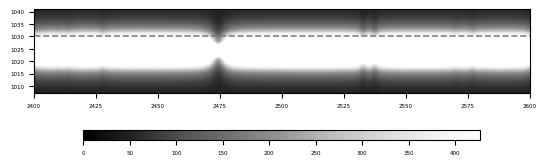

In [95]:
ceil=np.percentile(tot_data_com[6], 99.5)    
nor = ImageNormalize(tot_data_com[6], interval= ZScaleInterval(contrast=0.25), vmax=ceil, vmin=np.min(tot_data_com[6]))
plt.imshow(tot_data_com[5], cmap='Greys_r', norm=nor)

plt.colorbar(plt.imshow(tot_data_com[5], norm=nor, cmap='Greys_r'), shrink=0.8, aspect=40, \
             location='bottom',pad=0.1)

plt.hlines(y=1024+po,xmin=0,xmax=6143,ls='--',colors='gray', linewidth=1.2)
#plt.axis('off')

plt.xlim(2400, 2600)
plt.ylim(1024-17, 1024+17)

plt.savefig('./1709/zoom_2d.png', dpi=150)
plt.show()

In [5]:
#data for sky and star
data_log=pd.read_csv('./1709/star/stellar_simu.csv')

data_log_k=pd.read_csv('./1709/sky_noi/sky_simu.csv')

#read the files
filenames=glob.glob('./models_1683734698/bt-settl_m/lte*.dat') #use dat
filenames=sorted(filenames)[0:-6]

#set up the array for contrast data
cont=np.zeros((55, 2, 2046*3))

#noise parameter
read=6 #e-/pix
dark=0.003#e-/pix/s
dit=120
ndit=18
nspec=1
nspat=119

npix=nspec*nspat
ndark=dit*dark #e-/pix/exposure

#angular separation (pix)
po=int(np.ceil(0.319/0.059))

i=0
for filename in filenames:
    
    #read the planet file and consctruct the combined raw images
    
    data_log_p=pd.read_csv('./1709/planet/%s/planet_simu.csv'%filename[32:43])

    simu_planet=crires_simu(path_etc_local='./etc_cli.py', path_etc_input='./input_1709_p_AO.json', path_input_modi='./modi_input_1709_p_AO_2.json',\
             path_etc_output='./1709/planet/', target='planet', aperture_size=35, date='1709',\
        order_window=[[1921.318, 1961.128],[1989.978, 2031.165],[2063.711, 2106.392],[2143.087, 2187.386], [2228.786, 2274.835],\
        [2321.596, 2369.534], [2422.415, 2472.388]],\
        order_number=[29, 28, 27, 26, 25, 24, 23])

    tot_data_com, fig=simu_planet.combine(data_star=data_log, data_sky=data_log_k, data_p=data_log_p, ron=read, dark=ndark, d=po, \
                                focal_plane=(2048,2048*3), plot_combination=True)
    fig.savefig('./1709/planet/%s/combine.png'%filename[32:43])

    np.save('./1709/planet/%s/combine_focal_plane.npy'%filename[32:43], tot_data_com)
    
    
    #plot the contrast and save the average value
    po=int(np.ceil(0.319/0.059))

    p=planet_simu(disper_planet=data_log_p, disper_star=data_log)
    p2s_in, p2s_pl, plot_in, plot_pl=p.p_2_s(order_num=[29, 28, 27, 26, 25, 24, 23], planet_posi=po)
    
    plot_in.savefig('./1709/planet/%s/contrast_intrinsic.png'%filename[32:43], dpi=200)
    plot_pl.savefig('./1709/planet/%s/contrast_planet_posi.png'%filename[32:43], dpi=200)
    np.save('./1709/planet/%s/contrast.npy'%filename[32:43], np.array((p2s_in, p2s_pl)))
    
    a=p2s_in[2046*12:2046*15]
    b=p2s_pl[2046*12:2046*15]
    cont[i]=np.array((a,b))
    i+=1
    print ('done;%s'%filename[32:43])
    

/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te010-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te010-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te010-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te010-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te011-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te011-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te011-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te011-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te011-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te012-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te012-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te012-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te012-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te012-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te013-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te013-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te013-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te013-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te013-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te014-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te014-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te014-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te014-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te014-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te015-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te015-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te015-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te015-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te015-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te016-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te016-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te016-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te016-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te016-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te017-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te017-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te017-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te017-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_48934/80207929.py:117: UserWarning: Attempting to set identical bottom == top == -4.41 results in singular transformations; automatically expanding.
  ax.set_ylim(mi, ma*1.05)


done;te017-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te018-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te018-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te018-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te018-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te018-5.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te019-3.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te019-4.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te019-4.5-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te019-5.0-0


/Users/richard/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


done;te019-5.5-0


In [6]:
font = {'size': 8}
plt.rcParams.update({'font.size': font['size']})

parameter=np.zeros((55,3))


i=0
for j in filenames:
    parameter[i,0]=(int(j[35:37])*100)
    parameter[i,1]=(float(j[38:41]))
    parameter[i,2]=(float(j[42:45]))
    
    i+=1

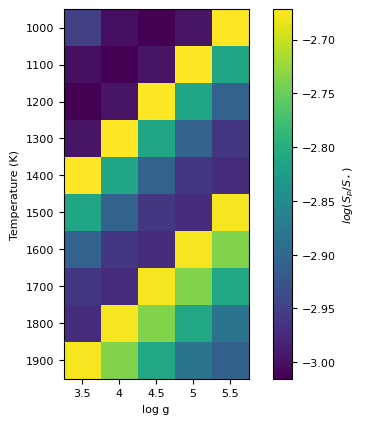

In [52]:
contrast_plane=np.zeros((10,5))
for i in range(contrast_plane.shape[0]):
    for j in range(contrast_plane.shape[1]): 
        contrast_plane[i][j]=np.nanmedian(cont[i+j][1])
        
plt.imshow(contrast_plane)

plt.xticks(np.arange(0,5),labels=[3.5,4,4.5,5,5.5])
plt.xlabel("log g")
plt.yticks(np.arange(0,10),labels=np.arange(1000,2000,100))
plt.ylabel("Temperature (K)")

plt.colorbar(label="$log(S_p/S_\star)$")
plt.savefig('./1709/contrast_plane.png',dpi=100)

In [7]:
log_g=[3.5,4,4.5,5,5.5]
contrast_plane_w=np.zeros((len(log_g),10,cont.shape[2]))
nu=0
a=1 #intrinsic or planet-posi
for x in log_g:
    log_fix=list(np.where(parameter[:,1]==x)[0])
    j=0
    for i in log_fix:
        contrast_plane_w[nu][j]=cont[i][a]
        j+=1
    nu+=1


/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_48934/3590194080.py:29: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  f.axis(['off','off','on','on'])
/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_48934/3590194080.py:29: UserWarning: Attempting to set identical bottom == top == [0.] results in singular transformations; automatically expanding.
  f.axis(['off','off','on','on'])
/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_48934/3590194080.py:29: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.
  f.axis(['off','off','on','on'])
/var/folders/w_/fqznltwj2pz2y345p5_rzn3r0000gn/T/ipykernel_48934/3590194080.py:29: UserWarning: Attempting to set identical bottom == top == [0.] results in singular transformations; automatically expanding.
  f.axis(['off','off','on','on'])
/var/folders/w_/fqznltwj2pz2y345

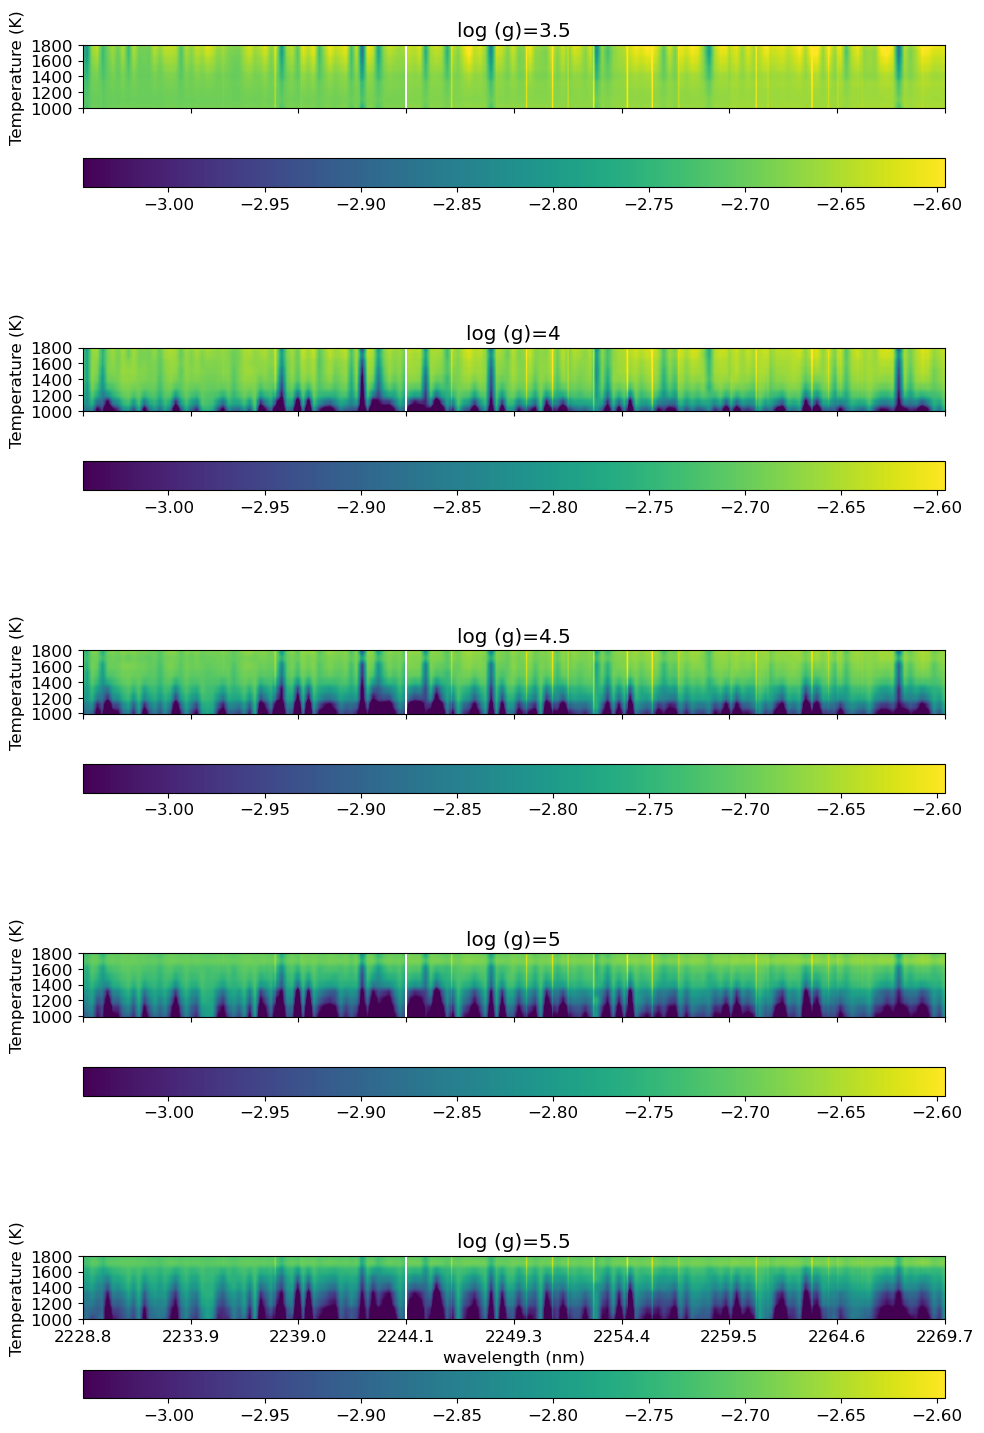

In [8]:
font = {'size': 12}
plt.rcParams.update({'font.size': font['size']})

mask=np.where(contrast_plane_w==0.0,True, False)

nor = ImageNormalize(contrast_plane_w, vmax=np.nanquantile(contrast_plane_w[~mask],0.995),\
                         vmin=np.nanquantile(contrast_plane_w[~mask],0.05),\
                        interval=ZScaleInterval(contrast=0.2)) 

fig,ax=plt.subplots(5,1, sharex=True, sharey=True, figsize=(10,16))
#plt.subplot(aspect='equal')
m=0
for m in range(len(log_g)):
    mask_m=np.where(contrast_plane_w[m]==0.)
    contrast_plane_w[m][mask_m]=np.nan
    
    f=ax[m]
    mapp=f.imshow(contrast_plane_w[m], norm=nor)  
    cbar=fig.colorbar(mapp, ax=f, location='bottom', aspect=30)
    
    grid=(2274.835-2228.786)/9
    f.set_yticks(np.arange(0,10,2),labels=np.arange(1000,2000,200))
    f.set_xticks(np.arange(0,2046*3,2046/3),labels=np.round(np.arange(2228.786, 2274.835, grid),1))
    f.set_title('log (g)=%s'%log_g[m])
    f.set_ylabel('Temperature (K)')
    if m==4:
        f.set_xticks(np.arange(0,2046*3,2046/3),labels=np.round(np.arange(2228.786, 2274.835, grid),1))
    else:
        f.axis(['off','off','on','on'])
    
    f.set_aspect(50)
        
plt.yticks(np.arange(0,10,2),labels=np.arange(1000,2000,200))
plt.xticks(np.arange(0,2046*3,2046/3),labels=np.round(np.arange(2228.786, 2274.835, grid),1))

plt.xlabel('wavelength (nm)')

plt.tight_layout()
plt.savefig('./1709/contrast_order25_pl.png',dpi=200)
plt.show()

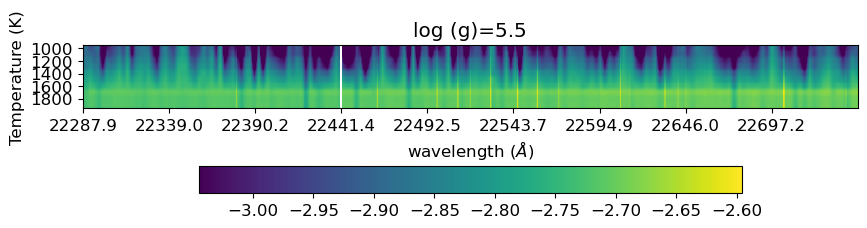

In [9]:
m=-1
plt.figure(figsize=(10,3))

mask_m=np.where(contrast_plane_w[m]==0.)
contrast_plane_w[m][mask_m]=np.nan

mapp=plt.imshow(contrast_plane_w[m], norm=nor, aspect=50)  
cbar=plt.colorbar(mapp, location='bottom', aspect=20, pad=0.25, shrink=0.7)

#if m==0:
#plt.ylim(8,1)

grid=(22748.35-22287.86)/9
plt.yticks(np.arange(0,10,2),labels=np.arange(1000,2000,200))
plt.xticks(np.arange(0,2046*3,2046/3),labels=np.round(np.arange(22287.86, 22748.35, grid),1))
plt.title('log (g)=%s'%log_g[m])
plt.ylabel('Temperature (K)')
plt.xlabel('wavelength ($\AA$)')

#plt.xlim(2046, 2200)

plt.savefig('./1709/contrast_order25_%s_pl.png'%log_g[m], dpi=200)

In [11]:
data=np.load('./1709/planet/te013-5.5-0/contrast.npy')

disper_planet=pd.read_csv('./1709/planet/te013-5.5-0/planet_simu.csv')

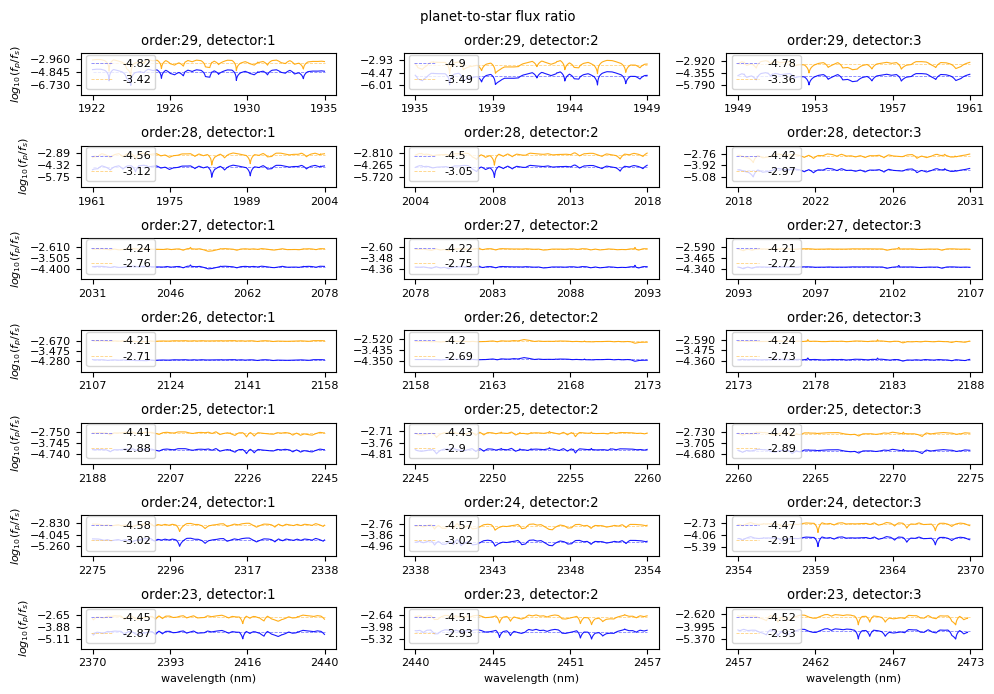

In [12]:
font = {'size': 8}
plt.rcParams.update({'font.size': font['size']})
order_num = np.linspace(29,23,7,dtype='int')
p_2_s_intr = data[0]
p_2_s_pl = data[1]

fig,axs=plt.subplots(len(order_num),3, figsize=(10, 7))

for i in range(len(order_num)):
    for j in range(3):
        ax=axs[i][j]
        ind=3*i+j
        wave_range = disper_planet.loc[2045*ind:2045*(ind+1)]['wavelength(nm)']

        ax.plot(p_2_s_intr[2046*ind:2046*(ind+1)],\
                linewidth=0.8, alpha=0.9, c='blue')
        me_in=np.nanmean(p_2_s_intr[2046*ind:2046*(ind+1)])
        ax.hlines(me_in, 0, 2046,ls='--', colors='blue', \
                  linewidth=0.6, alpha=0.5, label='%s'%np.round(me_in,2))
        
        ax.plot(p_2_s_pl[2046*ind:2046*(ind+1)],\
                linewidth=0.8, alpha=0.9, c='orange')
        me_pl=np.nanmean(p_2_s_pl[2046*ind:2046*(ind+1)])
        ax.hlines(me_pl, 0, 2046,ls='--', colors='orange', \
                  linewidth=0.6, alpha=0.5, label='%s'%np.round(me_pl,2))

        if ind + 3 >= len(order_num)*3:
            ax.set_xlabel('wavelength (nm)')
        if j%3 ==0: 
            ax.set_ylabel('$log_{10}(f_p/f_s)$')
        if ind%3 !=0 :
            ax.set_yticks([])

        ax.set_title('order:%s, detector:%s'%(order_num[i], j+1))
        #ax.set_yscale('log')

        mi=np.nanmin(p_2_s_intr[2046*ind:2046*(ind+1)])
        mi=np.round(mi,2)
        ma=np.nanmax(p_2_s_pl[2046*ind:2046*(ind+1)])
        ma=np.round(ma,2)

        ax.set_ylim(mi*1.2, ma*0.7)
        ax.set_yticks(np.linspace(mi, ma, 3))
        tick=np.linspace(np.ceil(wave_range.min()), np.ceil(wave_range.max()),4, dtype='int')
        ax.set_xticks(ticks=np.linspace(0,2046,4),\
                      labels=tick)
        #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.legend(loc='lower left')

fig.suptitle('planet-to-star flux ratio')
fig.subplots_adjust(hspace=1.3,wspace=0.3)
plt.tight_layout()

plt.savefig('./1709/planet_to_star_contrast.png', dpi=200)